# Gradient Boosting Classifier Model with Train/Val Stratification and Stratified K-Fold
---
The model in this notebook was strongly influenced by Natural Chan.  The following gradient boosted classifier will be used in an ordinal regression dataset. This gadient boosted classifier parameter searches are replicates of the base grad_boost_classifier notebook.

In an effort to model the highly imbalanced quality scores in the data set, two stratification techniques/operations will be activated.  All of the grid search fields will utilize the same parameters as the original grad_boost_classifyer notebook.  This was decided as to serve as a comparison to any changes in the run time required for the grid search and model computation time.

### Train-Test-Split with Stratify
* Within the train_test_split operation, a stratify term was added when splitting the training from the validation datasets. With the stratify parameter set to the distribution of quality scores within the original training dataset, the distribution of quality scores will be nearly the same bewteen the training and validation datasets.
* This operation was called from the default sklearn GradientBoostingClassifier model and used without any modifications,

### Stratified K-Fold
* Within the cross-verification operation, a stratification step will ensure the distribution of quality scores will be nearly the same bewteen the training and validation datasets on each fold.
* This parameter was activated in an attempt to improve the models ability to predict quality scores on an imbalanced training dataset, i.e. out of the 10 possible classes (0-9) only 3-8 are represented, and quality scores between 5-7 are the most common.
* This operation was called from the sklearn model_selection module and used without further modification


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, cohen_kappa_score

import time

from warnings import filterwarnings
filterwarnings('ignore')

In [4]:
# The 'ID' feature is already dropped from cleaning notebook

# Open all source files as a pd dataframe
# This dataset will be used to train the gradient boosted model
orig_train = pd.read_csv('https://project4-wine-quality-2023.s3.us-west-2.amazonaws.com/train.csv')

#This dataset will be used to evaluate again the Kaggle compitition entry submission
orig_test = pd.read_csv('https://project4-wine-quality-2023.s3.us-west-2.amazonaws.com/test.csv')

# Addition datasets to explore the GradBoost model on actual wine data
red_data = pd.read_csv('https://raw.githubusercontent.com/Nicholas-Simpson/Project-4/main/gradient_boost/cleaned_data/red_white_data_noID.csv')
white_data = pd.read_csv('https://raw.githubusercontent.com/Nicholas-Simpson/Project-4/main/gradient_boost/cleaned_data/white_data_noID.csv')
red_white_data = pd.read_csv('https://raw.githubusercontent.com/Nicholas-Simpson/Project-4/main/gradient_boost/cleaned_data/red_white_data_noID.csv')
trainable_data = pd.read_csv('https://raw.githubusercontent.com/Nicholas-Simpson/Project-4/main/gradient_boost/cleaned_data/trainable_data_noID.csv')

# Drop 'ID' columns
orig_test = orig_test.drop(columns='Id')
orig_train = orig_train.drop(columns='Id')

# Create a place to save any generated files
gb_txt_output_path = os.path.join('../grad boost output','classification reports')
gb_png_output_path = os.path.join('../grad boost output','confusion plots')
os.makedirs(gb_txt_output_path, exist_ok = True)
os.makedirs( gb_png_output_path, exist_ok = True)

In [5]:
#--------------------------------
#
# Define the dataset to use to on the model parameter grid search
#
dataset = red_white_data

data = "Red & White"
#
#--------------------------------

In [6]:
# Split the data into training and testing sets
X_train = dataset.drop('quality', axis=1)
y_train = dataset['quality'].copy()
X_test = dataset.copy()
quality_rating = list(y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  stratify= quality_rating,
                                                  test_size = 0.2, 
                                                  random_state = 42) #because it is the answer :)

# Investigate Gradient Boosted Model Parameters


In [7]:
# Create a Gradient Boosting Regressor
model = GradientBoostingClassifier()

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200], # number of weak learning trees
    'learning_rate': [0.01, 0.1, 0.2], # control possibility of overfitting.
    # Strong interaction with n_estimators: smaller learning rates require more n_estimators
    'max_depth': [3, 5, 7] #  size of each tree
}

# Use stratified k-fold cross-validation
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search with cross-validation, mark timer start
start_time = time.time()
grid_search = GridSearchCV(model, param_grid, cv=skfold, verbose=3)
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_gb = grid_search.best_estimator_
grid_search_time = time.time()

# Make predictions on the test data using the best model
y_pred = best_gb.predict(X_val)

# Report how long it took to complete Grid search and prediction
end_time = time.time()
grid_time = grid_search_time - start_time
pred_time = end_time - grid_search_time
tot_time = end_time - start_time

print(f"Time to complete Grid Search: {grid_time:.6f} seconds")
print(f"Time to complete prediction: {pred_time:.6f} seconds")
print(f"Total time to complete Grid Search and prediction: {tot_time:.6f} seconds")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.546 total time=   2.8s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.525 total time=   2.8s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.526 total time=   2.8s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.549 total time=   2.7s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.522 total time=   2.7s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.541 total time=   6.3s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.538 total time=   5.2s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.541 total time=   5.1s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.561 total time=   5.3s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.528 to

In [8]:
# Create a Gradient Boosting Classifier with the best hyperparameters
best_params = {
    'n_estimators': best_gb.n_estimators,
    'learning_rate': best_gb.learning_rate,
    'max_depth': best_gb.max_depth
}
retrained_model = GradientBoostingClassifier(**best_params) # the ** tells python to unpack the dictionary

# Retrain the model on the entire training dataset
start_retrain = time.time()
retrained_model.fit(X_train, y_train)

# Make predictions on the validation set (or test set if needed) using the retrained model
y_pred_retrained = retrained_model.predict(X_val)
end_retrain = time.time()

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average= 'weighted') # weighted average because the classification is not binary
precision = precision_score(y_val, y_pred, average= 'weighted')
recall = recall_score(y_val, y_pred, average= 'weighted')
kappa = cohen_kappa_score(y_val, y_pred, weights='quadratic')

# Determine how long it took to run model
retrain_time = end_retrain - start_retrain

print(f"Time to complete retrain model: {retrain_time:.4f}")

Time to complete retrain model: 13.4806


In [9]:
# Change the number of weak learner trees
# Create a Gradient Boosting Regressor
model_2 = GradientBoostingClassifier()

# Define the hyperparameter grid to search
param_grid_2 = {
    'n_estimators': [200, 400, 800],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [3, 5, 7]
}

# Use stratified k-fold cross-validation
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search with cross-validation
start_time_2 = time.time()
grid_search_2 = GridSearchCV(model_2, param_grid_2, cv=skfold, verbose=3)
grid_search_2.fit(X_train, y_train)

# Get the best model from grid search
best_gb_2 = grid_search_2.best_estimator_
grid_search_time_2 = time.time()

# Make predictions on the test data using the best model
y_pred_2 = best_gb_2.predict(X_val)

# Report how long it took to complete Grid search and prediction
end_time_2 = time.time()
grid_time_2 = grid_search_time_2 - start_time_2
pred_time_2 = end_time_2 - grid_search_time_2
tot_time_2 = end_time_2 - start_time_2

print(f"Time to complete Grid Search: {grid_time_2:.6f} seconds")
print(f"Time to complete prediction: {pred_time_2:.6f} seconds")
print(f"Total time to complete Grid Search and prediction: {tot_time_2:.6f} seconds")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=200;, score=0.497 total time=  10.1s
[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=200;, score=0.497 total time=  10.1s
[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=200;, score=0.500 total time=  10.0s
[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=200;, score=0.508 total time=  10.0s
[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=200;, score=0.492 total time=   9.8s
[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=400;, score=0.552 total time=  19.8s
[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=400;, score=0.524 total time=  19.8s
[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=400;, score=0.523 total time=  20.6s
[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=400;, score=0.547 total time=  19.8s
[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=400;,

In [10]:
# Create a Gradient Boosting Classifier with the best hyperparameters to retrain the model to calculate computation timing
best_params_2 = {
    'n_estimators': best_gb_2.n_estimators,
    'learning_rate': best_gb_2.learning_rate,
    'max_depth': best_gb_2.max_depth
}
retrained_model_2 = GradientBoostingClassifier(**best_params_2) # the ** tells python to unpack the dictionary

# Retrain the model on the entire training dataset
start_retrain_2 = time.time()
retrained_model_2.fit(X_train, y_train)

# Make predictions on the validation set (or test set if needed) using the retrained model
y_pred_retrained_2 = retrained_model_2.predict(X_val)
end_retrain_2 = time.time()

# Calculate metrics
accuracy_2 = accuracy_score(y_val, y_pred_2)
# the following metrics need to include the average type since the validation is ordinal and not binary
f1_2 = f1_score(y_val, y_pred_2, average= 'weighted')
precision_2 = precision_score(y_val, y_pred_2, average= 'weighted')
recall_2 = recall_score(y_val, y_pred_2, average= 'weighted')
kappa_2 = cohen_kappa_score(y_val, y_pred_2, weights='quadratic')

# Determine how long it took to run model
retrain_time_2 = end_retrain_2 - start_retrain_2

print(f"Time to complete retrain model: {retrain_time_2:.4f}")

Time to complete retrain model: 157.4626


In [11]:
# Change the number of weak learner trees
# Create a Gradient Boosting Regressor
model_3 = GradientBoostingClassifier()

# Define the hyperparameter grid to search
param_grid_3 = {
    'n_estimators': [200, 400, 800],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [2, 3, 5]
}

# Use stratified k-fold cross-validation
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search with cross-validation
start_time_3 = time.time()
grid_search_3 = GridSearchCV(model_3, param_grid_3, cv=skfold, verbose=3)
grid_search_3.fit(X_train, y_train)

# Get the best model from grid search
best_gb_3 = grid_search_3.best_estimator_
grid_search_time_3 = time.time()

# Make predictions on the test data using the best model
y_pred_3 = best_gb_3.predict(X_val)

# Report how long it took to complete Grid search and prediction
end_time_3 = time.time()
grid_time_3 = grid_search_time_3 - start_time_3
pred_time_3 = end_time_3 - grid_search_time_3
tot_time_3 = end_time_3 - start_time_3

print(f"Time to complete Grid Search: {grid_time_3:.6f} seconds")
print(f"Time to complete prediction: {pred_time_3:.6f} seconds")
print(f"Total time to complete Grid Search and prediction: {tot_time_3:.6f} seconds")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END learning_rate=0.001, max_depth=2, n_estimators=200;, score=0.437 total time=  10.6s
[CV 2/5] END learning_rate=0.001, max_depth=2, n_estimators=200;, score=0.502 total time=  10.0s
[CV 3/5] END learning_rate=0.001, max_depth=2, n_estimators=200;, score=0.512 total time=  10.4s
[CV 4/5] END learning_rate=0.001, max_depth=2, n_estimators=200;, score=0.437 total time=  10.4s
[CV 5/5] END learning_rate=0.001, max_depth=2, n_estimators=200;, score=0.501 total time=  10.1s
[CV 1/5] END learning_rate=0.001, max_depth=2, n_estimators=400;, score=0.544 total time=  20.5s
[CV 2/5] END learning_rate=0.001, max_depth=2, n_estimators=400;, score=0.524 total time=  20.4s
[CV 3/5] END learning_rate=0.001, max_depth=2, n_estimators=400;, score=0.523 total time=  20.2s
[CV 4/5] END learning_rate=0.001, max_depth=2, n_estimators=400;, score=0.548 total time=  20.9s
[CV 5/5] END learning_rate=0.001, max_depth=2, n_estimators=400;,

In [12]:
# Create a Gradient Boosting Classifier with the best hyperparameters to retrain the model to calculate computation timing
best_params_3 = {
    'n_estimators': best_gb_3.n_estimators,
    'learning_rate': best_gb_3.learning_rate,
    'max_depth': best_gb_3.max_depth
}
retrained_model_3 = GradientBoostingClassifier(**best_params_3) # the ** tells python to unpack the dictionary

# Retrain the model on the entire training dataset
start_retrain_3 = time.time()
retrained_model_3.fit(X_train, y_train)

# Make predictions on the validation set (or test set if needed) using the retrained model
y_pred_retrained_3 = retrained_model_3.predict(X_val)
end_retrain_3 = time.time()

# Calculate metrics
accuracy_3 = accuracy_score(y_val, y_pred_3)
# the following metrics need to include the average type since the validation is ordinal and not binary
f1_3 = f1_score(y_val, y_pred_3, average= 'weighted')
precision_3 = precision_score(y_val, y_pred_3, average= 'weighted')
recall_3 = recall_score(y_val, y_pred_3, average= 'weighted')
kappa_3 = cohen_kappa_score(y_val, y_pred_3, weights='quadratic')

# Determine how long it took to run model
retrain_time_3 = end_retrain_3 - start_retrain_3

print(f"Time to complete retrain model: {retrain_time_3:.4f}")

Time to complete retrain model: 23.9161


In [13]:
# Change the number of weak learner trees
# Create a Gradient Boosting Regressor
model_4 = GradientBoostingClassifier()

# Define the hyperparameter grid to search
param_grid_4 = {
    'n_estimators': [10, 20, 30, 40, 50, 75, 100, 150],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 3, 5, 7, 9]
}

# Use stratified k-fold cross-validation
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search with cross-validation
start_time_4 = time.time()
grid_search_4 = GridSearchCV(model_4, param_grid_4, cv=skfold, verbose=3)
grid_search_4.fit(X_train, y_train)

# Get the best model from grid search
best_gb_4 = grid_search_4.best_estimator_
grid_search_time_4 = time.time()

# Make predictions on the test data using the best model
y_pred_4 = best_gb_4.predict(X_val)

# Report how long it took to complete Grid search and prediction
end_time_4 = time.time()
grid_time_4 = grid_search_time_4 - start_time_4
pred_time_4 = end_time_4 - grid_search_time_4
tot_time_4 = end_time_4 - start_time_4

print(f"Time to complete Grid Search: {grid_time_4:.6f} seconds")
print(f"Time to complete prediction: {pred_time_4:.6f} seconds")
print(f"Total time to complete Grid Search and prediction: {tot_time_4:.6f} seconds")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV 1/5] END learning_rate=0.001, max_depth=2, n_estimators=10;, score=0.437 total time=   0.5s
[CV 2/5] END learning_rate=0.001, max_depth=2, n_estimators=10;, score=0.437 total time=   0.5s
[CV 3/5] END learning_rate=0.001, max_depth=2, n_estimators=10;, score=0.436 total time=   0.5s
[CV 4/5] END learning_rate=0.001, max_depth=2, n_estimators=10;, score=0.437 total time=   0.5s
[CV 5/5] END learning_rate=0.001, max_depth=2, n_estimators=10;, score=0.437 total time=   0.5s
[CV 1/5] END learning_rate=0.001, max_depth=2, n_estimators=20;, score=0.437 total time=   1.0s
[CV 2/5] END learning_rate=0.001, max_depth=2, n_estimators=20;, score=0.437 total time=   1.0s
[CV 3/5] END learning_rate=0.001, max_depth=2, n_estimators=20;, score=0.436 total time=   1.0s
[CV 4/5] END learning_rate=0.001, max_depth=2, n_estimators=20;, score=0.437 total time=   1.0s
[CV 5/5] END learning_rate=0.001, max_depth=2, n_estimators=20;, score=0

In [14]:
# Create a Gradient Boosting Classifier with the best hyperparameters to retrain the model to calculate computation timing
best_params_4 = {
    'n_estimators': best_gb_4.n_estimators,
    'learning_rate': best_gb_4.learning_rate,
    'max_depth': best_gb_4.max_depth
}
retrained_model_4 = GradientBoostingClassifier(**best_params_4) # the ** tells python to unpack the dictionary

# Retrain the model on the entire training dataset
start_retrain_4 = time.time()
retrained_model_4.fit(X_train, y_train)

# Make predictions on the validation set (or test set if needed) using the retrained model
y_pred_retrained_4 = retrained_model_4.predict(X_val)
end_retrain_4 = time.time()

# Calculate metrics
accuracy_4 = accuracy_score(y_val, y_pred_4)
# the following metrics need to include the average type since the validation is ordinal and not binary
f1_4 = f1_score(y_val, y_pred_4, average= 'weighted')
precision_4 = precision_score(y_val, y_pred_4, average= 'weighted')
recall_4 = recall_score(y_val, y_pred_4, average= 'weighted')
kappa_4 = cohen_kappa_score(y_val, y_pred_4, weights='quadratic')

# Determine how long it took to run model
retrain_time_4 = end_retrain_4 - start_retrain_4

print(f"Time to complete retrain model: {retrain_time_4:.4f}")

Time to complete retrain model: 34.3754


# Classification Reports

In [15]:
CR_1 = classification_report(y_val,y_pred)

print("First Search Results:")
print("------------------------------------")
txt_file_name = f"{gb_txt_output_path}/gbc_st_skf_{data} kappa: {kappa:.4f}   est: {best_gb.n_estimators}   LR: {best_gb.learning_rate}   depth: {best_gb.max_depth}  run_time: {retrain_time:.2f}.txt"
with open(txt_file_name, 'w') as txt_file:
    results=(
        f"Grid Search Parameters:\n"
        f"----------------------------------------------------------\n"
        f"Estimators used in grid search: {param_grid['n_estimators']}\n"
        f"Learning rates used in grid search: {param_grid['learning_rate']}\n"
        f"Tree node max depth in grid search: {param_grid['n_estimators']}\n"
        f"----------------------------------------------------------\n\n"
        
        f"Best Parameters Found:\n"
        f"----------------------------------------------------------\n"
        f"Best Estimators: {best_gb.n_estimators}\n"
        f"Best Learning Rate: {best_gb.learning_rate}\n"
        f"Best Max Depth: {best_gb.max_depth}\n"
        "----------------------------------------------------------\n\n"
        
        f"Classification Report\n"  
        f"-----------------------------------------------------------------------\n"
        f"{CR_1}\n"
        f"-----------------------------------------------------------------------\n\n"
        
        f"Model Performance:\n"
        f"----------------------------------------------------------\n"
        f"Accuracy: {accuracy:.2f}\n"
        f"F1: {f1:.2f}\n"
        f"Precision: {precision:.2f}\n"
        f"Recall: {recall:.2f}\n"
        f"Cohen Kappa Score, quadratic weighted: {kappa:.4f}\n"
        f"----------------------------------------------------------\n\n"

        f"Search and Training Duration\n"
        f"----------------------------------------------------------\n"
        f"Time to complete grid search: {grid_time:.6f} seconds\n"
        f"Time to run model with best params: {retrain_time:.6f} seconds\n"
        f"----------------------------------------------------------\n\n"
        f"***End Report***"
    )
    print(results)

    #save to txt file
    txt_file.write(results)

First Search Results:
------------------------------------
Grid Search Parameters:
----------------------------------------------------------
Estimators used in grid search: [50, 100, 200]
Learning rates used in grid search: [0.01, 0.1, 0.2]
Tree node max depth in grid search: [50, 100, 200]
----------------------------------------------------------

Best Parameters Found:
----------------------------------------------------------
Best Estimators: 100
Best Learning Rate: 0.2
Best Max Depth: 7
----------------------------------------------------------

Classification Report
-----------------------------------------------------------------------
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.42      0.19      0.26        43
           5       0.72      0.71      0.72       428
           6       0.68      0.76      0.72       567
           7       0.65      0.60      0.62       216
           8       0.73

In [16]:
CR_2 = classification_report(y_val,y_pred_2)

print("Second Search Resuults:")
print("------------------------------------")
txt_file_name = f"{gb_txt_output_path}/gbc_st_skf_{data} kappa: {kappa_2:.4f}   est: {best_gb_2.n_estimators}   LR: {best_gb_2.learning_rate}   depth: {best_gb_2.max_depth}  run_time: {retrain_time_2:.2f}.txt"
with open(txt_file_name, 'w') as txt_file:
    results=(
        f"Grid Search Parameters:\n"
        f"----------------------------------------------------------\n"
        f"Estimators used in grid search: {param_grid_2['n_estimators']}\n"
        f"Learning rates used in grid search: {param_grid_2['learning_rate']}\n"
        f"Tree node max depth in grid search: {param_grid_2['n_estimators']}\n"
        f"----------------------------------------------------------\n\n"
        
        f"Best Parameters Found:\n"
        f"----------------------------------------------------------\n"
        f"Best Estimators: {best_gb_2.n_estimators}\n"
        f"Best Learning Rate: {best_gb_2.learning_rate}\n"
        f"Best Max Depth: {best_gb_2.max_depth}\n"
        "----------------------------------------------------------\n\n"

        f"Classification Report\n"  
        f"-----------------------------------------------------------------------\n"
        f"{CR_2}\n"
        f"-----------------------------------------------------------------------\n\n"
        
        f"Model Performance:\n"
        f"----------------------------------------------------------\n"
        f"Accuracy: {accuracy_2:.2f}\n"
        f"F1: {f1_2:.2f}\n"
        f"Precision: {precision_2:.2f}\n"
        f"Recall: {recall_2:.2f}\n"
        f"Cohen Kappa Score, quadratic weighted: {kappa_2:.4f}\n"
        f"----------------------------------------------------------\n\n"

        f"Search and Training Duration\n"
        f"----------------------------------------------------------\n"
        f"Time to complete grid search: {grid_time_2:.6f} seconds\n"
        f"Time to run model with best params: {retrain_time_2:.6f} seconds\n"
        f"----------------------------------------------------------\n\n"
        f"***End Report***"
    )
    print(results)

    #save to txt file
    txt_file.write(results)

Second Search Resuults:
------------------------------------
Grid Search Parameters:
----------------------------------------------------------
Estimators used in grid search: [200, 400, 800]
Learning rates used in grid search: [0.001, 0.01, 0.1]
Tree node max depth in grid search: [200, 400, 800]
----------------------------------------------------------

Best Parameters Found:
----------------------------------------------------------
Best Estimators: 800
Best Learning Rate: 0.01
Best Max Depth: 7
----------------------------------------------------------

Classification Report
-----------------------------------------------------------------------
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.50      0.16      0.25        43
           5       0.72      0.69      0.70       428
           6       0.67      0.78      0.72       567
           7       0.69      0.61      0.65       216
           8    

In [17]:
CR_3 = classification_report(y_val,y_pred_3)

print("Third Search Results:")
print("------------------------------------")
txt_file_name = f"{gb_txt_output_path}/gbc_st_skf_{data} kappa: {kappa_3:.4f}   est: {best_gb_3.n_estimators}   LR: {best_gb_3.learning_rate}   depth: {best_gb_3.max_depth}  run_time: {retrain_time_3:.2f}.txt"
with open(txt_file_name, 'w') as txt_file:
    results=(
        f"Grid Search Parameters:\n"
        f"----------------------------------------------------------\n"
        f"Estimators used in grid search: {param_grid_3['n_estimators']}\n"
        f"Learning rates used in grid search: {param_grid_3['learning_rate']}\n"
        f"Tree node max depth in grid search: {param_grid_3['n_estimators']}\n"
        f"----------------------------------------------------------\n\n"
        
        f"Best Parameters Found:\n"
        f"----------------------------------------------------------\n"
        f"Best Estimators: {best_gb_3.n_estimators}\n"
        f"Best Learning Rate: {best_gb_3.learning_rate}\n"
        f"Best Max Depth: {best_gb_3.max_depth}\n"
        "----------------------------------------------------------\n\n"

        f"Classification Report\n"  
        f"-----------------------------------------------------------------------\n"
        f"{CR_3}\n"
        f"-----------------------------------------------------------------------\n\n"
        
        f"Model Performance:\n"
        f"----------------------------------------------------------\n"
        f"Accuracy: {accuracy_3:.2f}\n"
        f"F1: {f1_3:.2f}\n"
        f"Precision: {precision_3:.2f}\n"
        f"Recall: {recall_3:.2f}\n"
        f"Cohen Kappa Score, quadratic weighted: {kappa_3:.4f}\n"
        f"----------------------------------------------------------\n\n"

        f"Search and Training Duration\n"
        f"----------------------------------------------------------\n"
        f"Time to complete grid search: {grid_time_3:.6f} seconds\n"
        f"Time to run model with best params: {retrain_time_3:.6f} seconds\n"
        f"----------------------------------------------------------\n\n"
        f"***End Report***"
    )
    print(results)

    #save to txt file
    txt_file.write(results)

Third Search Results:
------------------------------------
Grid Search Parameters:
----------------------------------------------------------
Estimators used in grid search: [200, 400, 800]
Learning rates used in grid search: [0.001, 0.01, 0.1]
Tree node max depth in grid search: [200, 400, 800]
----------------------------------------------------------

Best Parameters Found:
----------------------------------------------------------
Best Estimators: 200
Best Learning Rate: 0.1
Best Max Depth: 5
----------------------------------------------------------

Classification Report
-----------------------------------------------------------------------
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.34      0.23      0.28        43
           5       0.74      0.69      0.71       428
           6       0.68      0.77      0.72       567
           7       0.65      0.61      0.63       216
           8       

In [18]:
CR_4 = classification_report(y_val,y_pred_4)

print("Fourth Search Results:")
print("------------------------------------")
txt_file_name = f"{gb_txt_output_path}/gbc_st_skf{data} kappa: {kappa_4:.4f}   est: {best_gb_4.n_estimators}   LR: {best_gb_4.learning_rate}   depth: {best_gb_4.max_depth}  run_time: {retrain_time_4:.2f}.txt"
with open(txt_file_name, 'w') as txt_file:
    results=(
        f"Grid Search Parameters:\n"
        f"----------------------------------------------------------\n"
        f"Estimators used in grid search: {param_grid_4['n_estimators']}\n"
        f"Learning rates used in grid search: {param_grid_4['learning_rate']}\n"
        f"Tree node max depth in grid search: {param_grid_4['n_estimators']}\n"
        f"----------------------------------------------------------\n\n"
        
        f"Best Parameters Found:\n"
        f"----------------------------------------------------------\n"
        f"Best Estimators: {best_gb_4.n_estimators}\n"
        f"Best Learning Rate: {best_gb_4.learning_rate}\n"
        f"Best Max Depth: {best_gb_4.max_depth}\n"
        "----------------------------------------------------------\n\n"

        f"Classification Report\n"  
        f"-----------------------------------------------------------------------\n"
        f"{CR_4}\n"
        f"-----------------------------------------------------------------------\n\n"
        
        
        f"Model Performance:\n"
        f"----------------------------------------------------------\n"
        f"Accuracy: {accuracy_4:.2f}\n"
        f"F1: {f1_4:.2f}\n"
        f"Precision: {precision_4:.2f}\n"
        f"Recall: {recall_4:.2f}\n"
        f"Cohen Kappa Score, quadratic weighted: {kappa_4:.4f}\n"
        f"----------------------------------------------------------\n\n"

        f"Search and Training Duration\n"
        f"----------------------------------------------------------\n"
        f"Time to complete grid search: {grid_time_4:.6f} seconds\n"
        f"Time to run model with best params: {retrain_time_4:.6f} seconds\n"
        f"----------------------------------------------------------\n\n"
        f"***End Report***"
    )
    print(results)

    #save to txt file
    txt_file.write(results)

Fourth Search Results:
------------------------------------
Grid Search Parameters:
----------------------------------------------------------
Estimators used in grid search: [10, 20, 30, 40, 50, 75, 100, 150]
Learning rates used in grid search: [0.001, 0.01, 0.05, 0.1, 0.2]
Tree node max depth in grid search: [10, 20, 30, 40, 50, 75, 100, 150]
----------------------------------------------------------

Best Parameters Found:
----------------------------------------------------------
Best Estimators: 150
Best Learning Rate: 0.2
Best Max Depth: 9
----------------------------------------------------------

Classification Report
-----------------------------------------------------------------------
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.35      0.14      0.20        43
           5       0.73      0.70      0.72       428
           6       0.68      0.79      0.73       567
           7       0.70

# Confusion Matrix

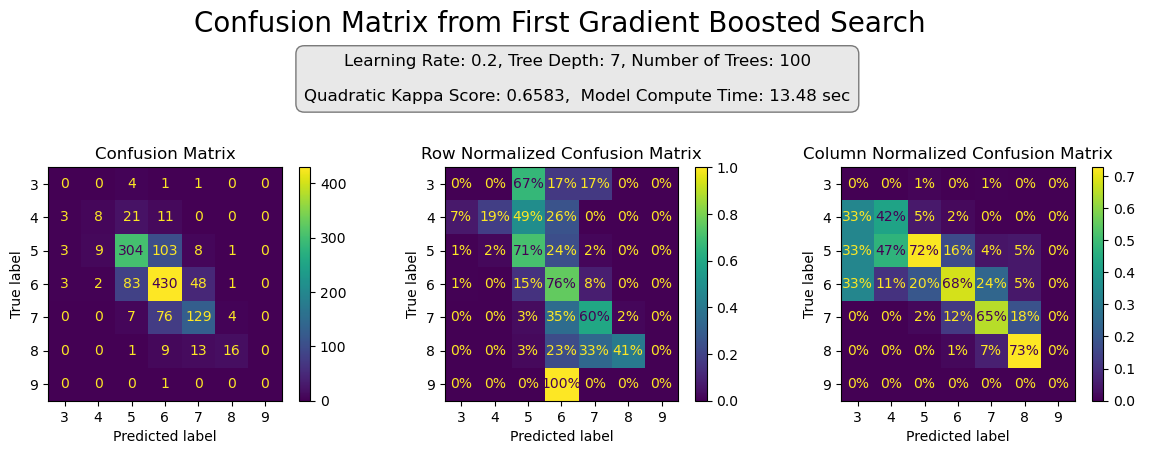

In [19]:
# Create the figure and gridspec
fig = plt.figure(figsize = (12,4.5))
grid_spec = GridSpec(3, 3, figure=fig, width_ratios = [1,1,1], height_ratios=[1,2,10])

# Model specs subplot
model_specs=  f"Learning Rate: {best_gb.learning_rate}, Tree Depth: {best_gb.max_depth}, Number of Trees: {best_gb.n_estimators}\n\nQuadratic Kappa Score: {kappa:.4f},  Model Compute Time: {retrain_time:.2f} sec"   
center_ax = fig.add_subplot(grid_spec[1, :])

# plt.center_ax_adjust(hspace = 0.5)
center_text = center_ax.text(0.5, 0.55, model_specs, ha='center', fontsize=12,
                           bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=0.5'))
center_ax.axis('off')

# Confusion Matrix Subplot
conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred, ax=fig.add_subplot(grid_spec[2, 0]))
conf_matrix_display.ax_.set_title("Confusion Matrix")

# Row (True) Normalized Confusion Matrix Subplot
row_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred,
                                                                         normalize='true',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 1]))
row_normalized_conf_matrix_display.ax_.set_title("Row Normalized Confusion Matrix")

# Column (Predicted) Normalized Confusion Matrix Subplot
clm_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred,
                                                                         normalize='pred',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 2]))
clm_normalized_conf_matrix_display.ax_.set_title("Column Normalized Confusion Matrix")

# Adjust Layout
plt.tight_layout()
fig.suptitle("Confusion Matrix from First Gradient Boosted Search", fontsize=20)

# Save and show the figure
output_filename = f"{gb_png_output_path}/gb_st_skf_cm_{data} kappa={kappa:.4f}  est: {best_gb.n_estimators}   LR: {best_gb.learning_rate}   depth: {best_gb.max_depth}  run_time: {retrain_time:.2f}.png"
plt.savefig(output_filename)
plt.show()

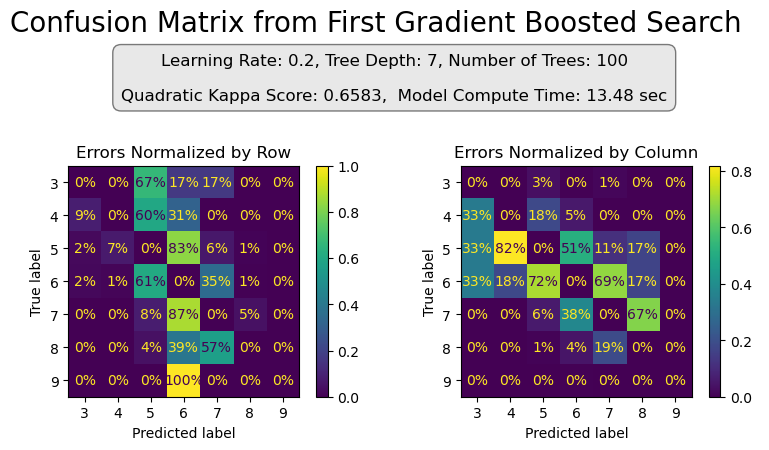

In [20]:
# Create the figure and gridspec
fig = plt.figure(figsize = (8,4.5))
grid_spec = GridSpec(3, 2, figure=fig, width_ratios = [1,1], height_ratios=[1,2,10])

# Model specs subplot
model_specs=  f"Learning Rate: {best_gb.learning_rate}, Tree Depth: {best_gb.max_depth}, Number of Trees: {best_gb.n_estimators}\n\nQuadratic Kappa Score: {kappa:.4f},  Model Compute Time: {retrain_time:.2f} sec"   
center_ax = fig.add_subplot(grid_spec[1, :])

# plt.center_ax_adjust(hspace = 0.5)
center_text = center_ax.text(0.5, 0.55, model_specs, ha='center', fontsize=12,
                           bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=0.5'))
center_ax.axis('off')

sample_weight = (y_pred != y_val)
# Row (True) Normalized Confusion Matrix Subplot
normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred,
                                                                         sample_weight = sample_weight,
                                                                         normalize='true',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 0]))
normalized_conf_matrix_display.ax_.set_title("Errors Normalized by Row")

# Column (Predicted) Normalized Confusion Matrix Subplot
normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred,
                                                                         sample_weight = sample_weight,
                                                                         normalize='pred',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 1]))
normalized_conf_matrix_display.ax_.set_title("Errors Normalized by Column")

# Adjust Layout
plt.tight_layout()
fig.suptitle("Confusion Matrix from First Gradient Boosted Search", fontsize=20)

# Save and show the figure
output_filename = f"{gb_png_output_path}/gb_st_skf_cm_err_{data} kappa={kappa:.4f}  est: {best_gb.n_estimators}   LR: {best_gb.learning_rate}   depth: {best_gb.max_depth}  run_time: {retrain_time:.2f}.png"
plt.savefig(output_filename)
plt.show()

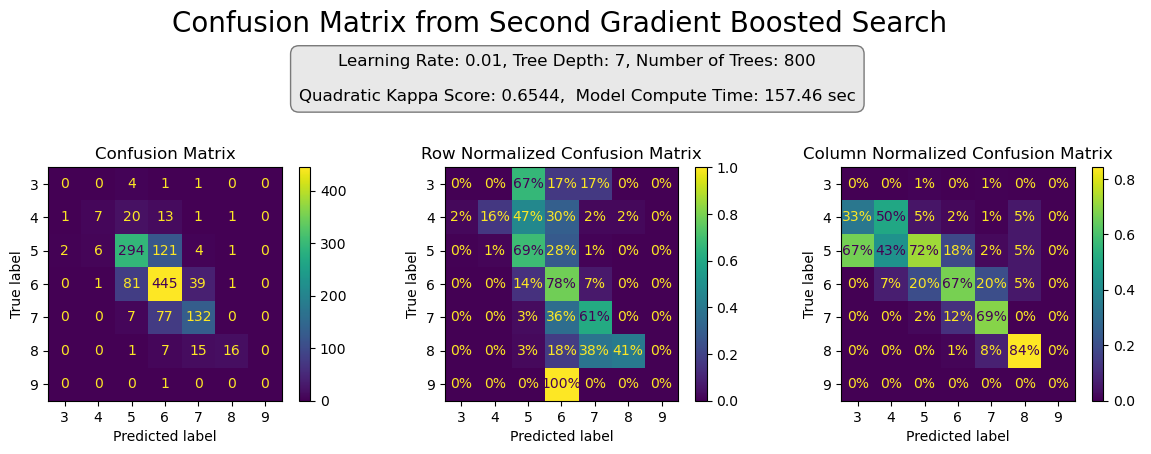

In [21]:
# Create the figure and gridspec
fig = plt.figure(figsize = (12,4.5))
grid_spec = GridSpec(3, 3, figure=fig, width_ratios = [1,1,1], height_ratios=[1,2,10])

# Model specs subplot
model_specs_2 =  f"Learning Rate: {best_gb_2.learning_rate}, Tree Depth: {best_gb_2.max_depth}, Number of Trees: {best_gb_2.n_estimators}\n\nQuadratic Kappa Score: {kappa_2:.4f},  Model Compute Time: {retrain_time_2:.2f} sec"   
center_ax = fig.add_subplot(grid_spec[1, :])

# plt.center_ax_adjust(hspace = 0.5)
center_text = center_ax.text(0.5, 0.55, model_specs_2, ha='center', fontsize=12,
                           bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=0.5'))
center_ax.axis('off')

# Confusion Matrix Subplot
conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_2, ax=fig.add_subplot(grid_spec[2, 0]))
conf_matrix_display.ax_.set_title("Confusion Matrix")

# Row (True) Normalized Confusion Matrix Subplot
row_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_2,
                                                                         normalize='true',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 1]))
row_normalized_conf_matrix_display.ax_.set_title("Row Normalized Confusion Matrix")

# Column (Predicted) Normalized Confusion Matrix Subplot
clm_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_2,
                                                                         normalize='pred',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 2]))
clm_normalized_conf_matrix_display.ax_.set_title("Column Normalized Confusion Matrix")

# Adjust Layout
plt.tight_layout()
fig.suptitle("Confusion Matrix from Second Gradient Boosted Search", fontsize=20)

# Save and show the figure
output_filename = f"{gb_png_output_path}/gb_st_skf_cm_{data} kappa={kappa_2:.4f}  est: {best_gb_2.n_estimators}   LR: {best_gb_2.learning_rate}   depth: {best_gb_2.max_depth}  run_time: {retrain_time_2:.2f}.png"
plt.savefig(output_filename)
plt.show()

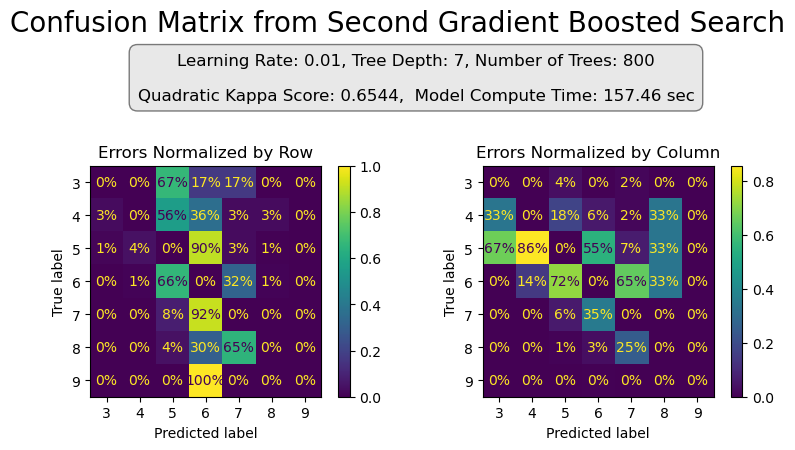

In [22]:
# Create the figure and gridspec
fig = plt.figure(figsize = (8,4.5))
grid_spec = GridSpec(3, 2, figure=fig, width_ratios = [1,1], height_ratios=[1,2,10])

# Model specs subplot
model_specs_2=  f"Learning Rate: {best_gb_2.learning_rate}, Tree Depth: {best_gb_2.max_depth}, Number of Trees: {best_gb_2.n_estimators}\n\nQuadratic Kappa Score: {kappa_2:.4f},  Model Compute Time: {retrain_time_2:.2f} sec"   
center_ax = fig.add_subplot(grid_spec[1, :])

# plt.center_ax_adjust(hspace = 0.5)
center_text = center_ax.text(0.5, 0.55, model_specs_2, ha='center', fontsize=12,
                           bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=0.5'))
center_ax.axis('off')

sample_weight = (y_pred_2 != y_val)
# Row (True) Normalized Confusion Matrix Subplot
row_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_2,
                                                                         sample_weight = sample_weight,
                                                                         normalize='true',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 0]))
row_normalized_conf_matrix_display.ax_.set_title("Errors Normalized by Row")

# Column (Predicted) Normalized Confusion Matrix Subplot
clm_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_2,
                                                                         sample_weight = sample_weight,
                                                                         normalize='pred',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 1]))
clm_normalized_conf_matrix_display.ax_.set_title("Errors Normalized by Column")

# Adjust Layout
plt.tight_layout()
fig.suptitle("Confusion Matrix from Second Gradient Boosted Search", fontsize=20)

# Save and show the figure
output_filename = f"{gb_png_output_path}/gb_st_skf_cm_err_{data} kappa={kappa_2:.4f}  est: {best_gb_2.n_estimators}   LR: {best_gb_2.learning_rate}   depth: {best_gb_2.max_depth}  run_time: {retrain_time_2:.2f}.png"
plt.savefig(output_filename)
plt.show()

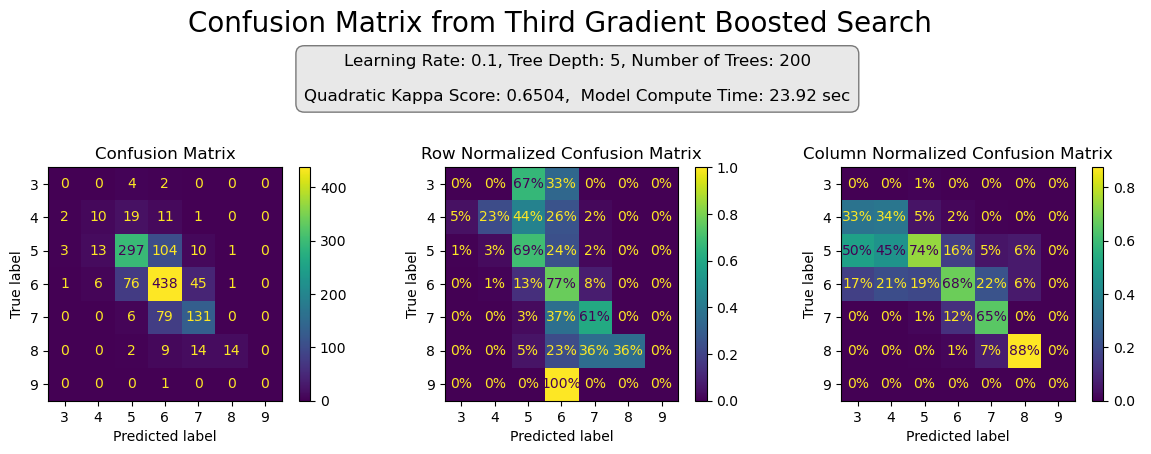

In [23]:
# Create the figure and gridspec
fig = plt.figure(figsize = (12,4.5))
grid_spec = GridSpec(3, 3, figure=fig, width_ratios = [1,1,1], height_ratios=[1,2,10])

# Model specs subplot
model_specs_3 =  f"Learning Rate: {best_gb_3.learning_rate}, Tree Depth: {best_gb_3.max_depth}, Number of Trees: {best_gb_3.n_estimators}\n\nQuadratic Kappa Score: {kappa_3:.4f},  Model Compute Time: {retrain_time_3:.2f} sec"   
center_ax = fig.add_subplot(grid_spec[1, :])

# plt.center_ax_adjust(hspace = 0.5)
center_text = center_ax.text(0.5, 0.55, model_specs_3, ha='center', fontsize=12,
                           bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=0.5'))
center_ax.axis('off')

# Confusion Matrix Subplot
conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_3, ax=fig.add_subplot(grid_spec[2, 0]))
conf_matrix_display.ax_.set_title("Confusion Matrix")

# Row (True) Normalized Confusion Matrix Subplot
row_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_3,
                                                                         normalize='true',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 1]))
row_normalized_conf_matrix_display.ax_.set_title("Row Normalized Confusion Matrix")

# Column (Predicted) Normalized Confusion Matrix Subplot
clm_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_3,
                                                                         normalize='pred',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 2]))
clm_normalized_conf_matrix_display.ax_.set_title("Column Normalized Confusion Matrix")

# Adjust Layout
plt.tight_layout()
fig.suptitle("Confusion Matrix from Third Gradient Boosted Search", fontsize=20)

# Save and show the figure
output_filename = f"{gb_png_output_path}/gb_st_skf_cm_{data} kappa={kappa_3:.4f}  est: {best_gb_3.n_estimators}   LR: {best_gb_3.learning_rate}   depth: {best_gb_3.max_depth}  run_time: {retrain_time_3:.2f}.png"
plt.savefig(output_filename)
plt.show()

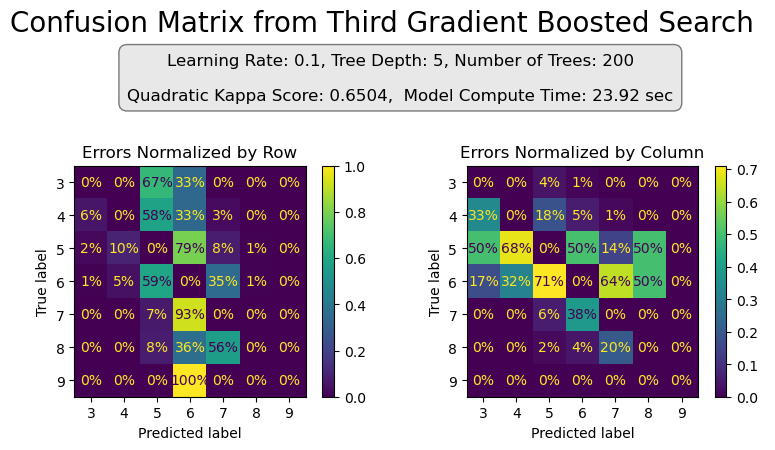

In [24]:
# Create the figure and gridspec
fig = plt.figure(figsize = (8,4.5))
grid_spec = GridSpec(3, 2, figure=fig, width_ratios = [1,1], height_ratios=[1,2,10])

# Model specs subplot
model_specs_3 =  f"Learning Rate: {best_gb_3.learning_rate}, Tree Depth: {best_gb_3.max_depth}, Number of Trees: {best_gb_3.n_estimators}\n\nQuadratic Kappa Score: {kappa_3:.4f},  Model Compute Time: {retrain_time_3:.2f} sec"   
center_ax = fig.add_subplot(grid_spec[1, :])

# plt.center_ax_adjust(hspace = 0.5)
center_text = center_ax.text(0.5, 0.55, model_specs_3, ha='center', fontsize=12,
                           bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=0.5'))
center_ax.axis('off')

sample_weight = (y_pred_3 != y_val)
# Row (True) Normalized Confusion Matrix Subplot
row_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_3,
                                                                         sample_weight = sample_weight,
                                                                         normalize='true',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 0]))
row_normalized_conf_matrix_display.ax_.set_title("Errors Normalized by Row")

# Column (Predicted) Normalized Confusion Matrix Subplot
clm_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_3,
                                                                         sample_weight = sample_weight,
                                                                         normalize='pred',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 1]))
clm_normalized_conf_matrix_display.ax_.set_title("Errors Normalized by Column")

# Adjust Layout
plt.tight_layout()
fig.suptitle("Confusion Matrix from Third Gradient Boosted Search", fontsize=20)

# Save and show the figure
output_filename = f"{gb_png_output_path}/gb_st_skf_cm_err_{data} kappa={kappa_3:.4f}  est: {best_gb_3.n_estimators}   LR: {best_gb_3.learning_rate}   depth: {best_gb_3.max_depth}  run_time: {retrain_time_3:.2f}.png"
plt.savefig(output_filename)
plt.show()

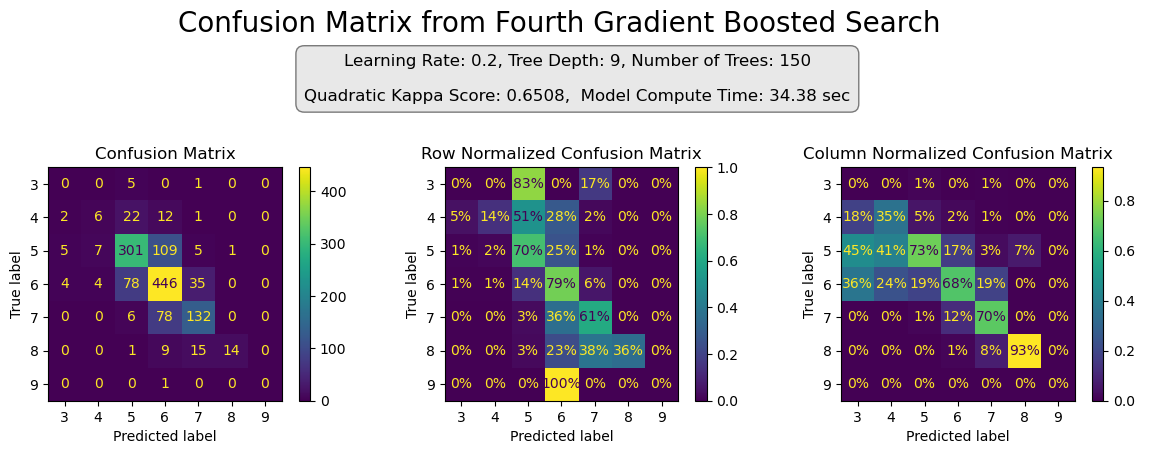

In [25]:
# Create the figure and gridspec
fig = plt.figure(figsize = (12,4.5))
grid_spec = GridSpec(3, 3, figure=fig, width_ratios = [1,1,1], height_ratios=[1,2,10])

# Model specs subplot
model_specs_4 =  f"Learning Rate: {best_gb_4.learning_rate}, Tree Depth: {best_gb_4.max_depth}, Number of Trees: {best_gb_4.n_estimators}\n\nQuadratic Kappa Score: {kappa_4:.4f},  Model Compute Time: {retrain_time_4:.2f} sec"   
center_ax = fig.add_subplot(grid_spec[1, :])

# plt.center_ax_adjust(hspace = 0.5)
center_text = center_ax.text(0.5, 0.55, model_specs_4, ha='center', fontsize=12,
                           bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=0.5'))
center_ax.axis('off')

# Confusion Matrix Subplot
conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_4, ax=fig.add_subplot(grid_spec[2, 0]))
conf_matrix_display.ax_.set_title("Confusion Matrix")

# Row (True) Normalized Confusion Matrix Subplot
row_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_4,
                                                                         normalize='true',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 1]))
row_normalized_conf_matrix_display.ax_.set_title("Row Normalized Confusion Matrix")

# Column (Predicted) Normalized Confusion Matrix Subplot
clm_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_4,
                                                                         normalize='pred',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 2]))
clm_normalized_conf_matrix_display.ax_.set_title("Column Normalized Confusion Matrix")

# Adjust Layout
plt.tight_layout()
fig.suptitle("Confusion Matrix from Fourth Gradient Boosted Search", fontsize=20)

# Save and show the figure
output_filename = f"{gb_png_output_path}/gb_st_skf_cm_{data} kappa={kappa_4:.4f}  est: {best_gb_4.n_estimators}   LR: {best_gb_4.learning_rate}   depth: {best_gb_4.max_depth}  run_time: {retrain_time_4:.2f}.png"
plt.savefig(output_filename)
plt.show()

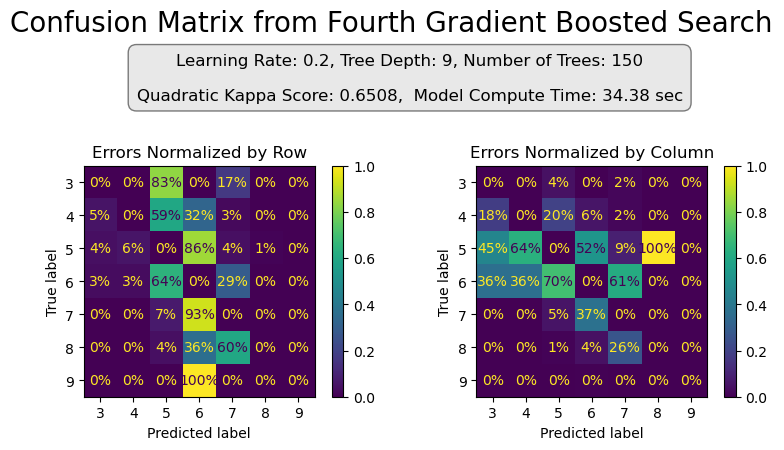

In [26]:
# Create the figure and gridspec
fig = plt.figure(figsize = (8,4.5))
grid_spec = GridSpec(3, 2, figure=fig, width_ratios = [1,1], height_ratios=[1,2,10])

# Model specs subplot
model_specs_4 =  f"Learning Rate: {best_gb_4.learning_rate}, Tree Depth: {best_gb_4.max_depth}, Number of Trees: {best_gb_4.n_estimators}\n\nQuadratic Kappa Score: {kappa_4:.4f},  Model Compute Time: {retrain_time_4:.2f} sec"   
center_ax = fig.add_subplot(grid_spec[1, :])

# plt.center_ax_adjust(hspace = 0.5)
center_text = center_ax.text(0.5, 0.55, model_specs_4, ha='center', fontsize=12,
                           bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=0.5'))
center_ax.axis('off')

sample_weight = (y_pred_4 != y_val)
# Row (True) Normalized Confusion Matrix Subplot
row_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_4,
                                                                         sample_weight = sample_weight,
                                                                         normalize='true',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 0]))
row_normalized_conf_matrix_display.ax_.set_title("Errors Normalized by Row")

# Column (Predicted) Normalized Confusion Matrix Subplot
clm_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_4,
                                                                         sample_weight = sample_weight,
                                                                         normalize='pred',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 1]))
clm_normalized_conf_matrix_display.ax_.set_title("Errors Normalized by Column")

# Adjust Layout
plt.tight_layout()
fig.suptitle("Confusion Matrix from Fourth Gradient Boosted Search", fontsize=20)

# Save and show the figure
output_filename = f"{gb_png_output_path}/gb_st_skf_cm_err_{data} kappa={kappa_4:.4f}  est: {best_gb_4.n_estimators}   LR: {best_gb_4.learning_rate}   depth: {best_gb_4.max_depth}  run_time: {retrain_time_4:.2f}.png"
plt.savefig(output_filename)
plt.show()

In [ ]:
# Stop here.  Model comparisons (i.e. future work) continues below this cell

# Compare best paraeters on actual wine data from research group
Using the stratified data splitting and stratified k-fold resuls, use the best parameters to predict quality scores on the datasets from the Portuguese wine research group

In [4]:
long_model = {
    'n_estimators': 400,
    'learning_rate': 0.01,
    'max_depth': 3
}

short_model = {
    'n_estimators': 30,
    'learning_rate': 0.05,
    'max_depth': 2
}

In [6]:
# Split the data into training and testing sets
X_train_red = red_data.drop('quality', axis=1)
y_train_red = red_data['quality'].copy()
X_test_red = red_data.copy()
quality_rating_red = list(y_train_red)
X_train_red, X_val_red, y_train_red, y_val_red = train_test_split(X_train_red, 
                                                  y_train_red, 
                                                  stratify= quality_rating_red,
                                                  test_size = 0.2, 
                                                  random_state = 42) #because it is the answer :)

In [7]:
# Split the data into training and testing sets
X_train_wh = white_data.drop('quality', axis=1)
y_train_wh = white_data['quality'].copy()
X_test_wh = white_data.copy()
quality_rating_wh = list(y_train_wh)
X_train_wh, X_val_wh, y_train_wh, y_val_wh = train_test_split(X_train_wh, 
                                                  y_train_wh, 
                                                  stratify= quality_rating_wh,
                                                  test_size = 0.2, 
                                                  random_state = 42) #because it is the answer :)

In [8]:
# Split the data into training and testing sets
X_train_rwh = red_white_data.drop('quality', axis=1)
y_train_rwh = red_white_data['quality'].copy()
X_test_rwh = red_white_data.copy()
quality_rating_rwh = list(y_train_rwh)
X_train_rwh, X_val_rwh, y_train_rwh, y_val_rwh = train_test_split(X_train_rwh, 
                                                  y_train_rwh, 
                                                  stratify= quality_rating_rwh,
                                                  test_size = 0.2, 
                                                  random_state = 42) #because it is the answer :)

In [15]:
red_model_1 = GradientBoostingClassifier(**long_model, verbose = 1) # the ** tells python to unpack the dictionary

# Retrain the model on the entire training dataset
start_red_1 = time.time()
red_model_1.fit(X_train_red, y_train_red)

# Make predictions on the validation set (or test set if needed) using the retrained model
y_pred_red_1 = red_model_1.predict(X_val_red)
end_red_1 = time.time()

# Calculate metrics
accuracy_red_1 = accuracy_score(y_val_red, y_pred_red_1)
# the following metrics need to include the average type since the validation is ordinal and not binary
f1_red_1 = f1_score(y_val_red, y_pred_red_1, average= 'weighted')
precision_red_1 = precision_score(y_val_red, y_pred_red_1, average= 'weighted')
recall_red_1 = recall_score(y_val_red, y_pred_red_1, average= 'weighted')
kappa_red_1 = cohen_kappa_score(y_val_red, y_pred_red_1, weights='quadratic')

# Determine how long it took to run model
red_time_1 = end_red_1 - start_red_1

print(f"Time to complete retrain model: {red_time_1:.4f}")
print()
print(f"kappa = {kappa_red_1}")

red_model_2 = GradientBoostingClassifier(**short_model, verbose = 1) # the ** tells python to unpack the dictionary

# Retrain the model on the entire training dataset
start_red_2 = time.time()
red_model_2.fit(X_train_red, y_train_red)

# Make predictions on the validation set (or test set if needed) using the retrained model
y_pred_red_2 = red_model_2.predict(X_val_red)
end_red_2 = time.time()

# Calculate metrics
accuracy_red_2 = accuracy_score(y_val_red, y_pred_red_2)
# the following metrics need to include the average type since the validation is ordinal and not binary
f1_red_2 = f1_score(y_val_red, y_pred_red_2, average= 'weighted')
precision_red_2 = precision_score(y_val_red, y_pred_red_2, average= 'weighted')
recall_red_2 = recall_score(y_val_red, y_pred_red_2, average= 'weighted')
kappa_red_2 = cohen_kappa_score(y_val_red, y_pred_red_2, weights='quadratic')

# Determine how long it took to run model
red_time_2 = end_red_2 - start_red_2

print(f"Time to complete retrain model: {red_time_2:.4f}")
print()
print(f"kappa = {kappa_red_2}")

      Iter       Train Loss   Remaining Time 
         1           1.2646           27.47s
         2           1.2591           28.26s
         3           1.2542           27.83s
         4           1.2494           27.31s
         5           1.2449           26.47s
         6           1.2405           25.84s
         7           1.2363           25.55s
         8           1.2322           25.18s
         9           1.2282           24.93s
        10           1.2243           24.80s
        20           1.1903           23.62s
        30           1.1621           22.79s
        40           1.1387           22.00s
        50           1.1184           21.33s
        60           1.1008           20.68s
        70           1.0856           20.10s
        80           1.0716           19.44s
        90           1.0592           18.86s
       100           1.0482           18.27s
       200           0.9758           12.08s
       300           0.9285            6.04s
       40

In [17]:
wh_model_1 = GradientBoostingClassifier(**long_model, verbose = 1) # the ** tells python to unpack the dictionary

# Retrain the model on the entire training dataset
start_wh_1 = time.time()
wh_model_1.fit(X_train_wh, y_train_wh)

# Make predictions on the validation set (or test set if needed) using the retrained model
y_pred_wh_1 = wh_model_1.predict(X_val_wh)
end_wh_1 = time.time()

# Calculate metrics
accuracy_wh_1 = accuracy_score(y_val_wh, y_pred_wh_1)
# the following metrics need to include the average type since the validation is ordinal and not binary
f1_wh_1 = f1_score(y_val_wh, y_pred_wh_1, average= 'weighted')
precision_wh_1 = precision_score(y_val_wh, y_pred_wh_1, average= 'weighted')
recall_wh_1 = recall_score(y_val_wh, y_pred_wh_1, average= 'weighted')
kappa_wh_1 = cohen_kappa_score(y_val_wh, y_pred_wh_1, weights='quadratic')

# Determine how long it took to run model
wh_time_1 = end_wh_1 - start_wh_1

print(f"Time to complete retrain model: {wh_time_1:.4f}")
print()
print(f"kappa = {kappa_wh_1}")

wh_model_2 = GradientBoostingClassifier(**short_model, verbose = 1) # the ** tells python to unpack the dictionary

# Retrain the model on the entire training dataset
start_wh_2 = time.time()
wh_model_2.fit(X_train_wh, y_train_wh)

# Make predictions on the validation set (or test set if needed) using the retrained model
y_pred_wh_2 = wh_model_2.predict(X_val_wh)
end_wh_2 = time.time()

# Calculate metrics
accuracy_wh_2 = accuracy_score(y_val_wh, y_pred_wh_2)
# the following metrics need to include the average type since the validation is ordinal and not binary
f1_wh_2 = f1_score(y_val_wh, y_pred_wh_2, average= 'weighted')
precision_wh_2 = precision_score(y_val_wh, y_pred_wh_2, average= 'weighted')
recall_wh_2 = recall_score(y_val_wh, y_pred_wh_2, average= 'weighted')
kappa_wh_2 = cohen_kappa_score(y_val_wh, y_pred_wh_2, weights='quadratic')

# Determine how long it took to run model
wh_time_2 = end_wh_2 - start_wh_2

print(f"Time to complete retrain model: {wh_time_2:.4f}")
print()
print(f"kappa = {kappa_wh_2}")

      Iter       Train Loss   Remaining Time 
         1           1.2786           23.67s
         2           1.2711           22.85s
         3           1.2655           22.52s
         4           1.2602           21.86s
         5           1.2551           21.74s
         6           1.2503           21.10s
         7           1.2456           20.62s
         8           1.2411           20.30s
         9           1.2368           20.07s
        10           1.2325           19.82s
        20           1.1960           18.37s
        30           1.1654           17.89s
        40           1.1406           18.52s
        50           1.1183           18.54s
        60           1.0999           18.13s
        70           1.0838           17.41s
        80           1.0697           16.83s
        90           1.0570           16.06s
       100           1.0458           15.35s
       200           0.9575            9.72s
       300           0.9062            4.76s
       40

In [19]:
rwh_model_1 = GradientBoostingClassifier(**long_model, verbose = 1) # the ** tells python to unpack the dictionary

# Retrain the model on the entire training dataset
start_rwh_1 = time.time()
rwh_model_1.fit(X_train_rwh, y_train_rwh)

# Make predictions on the validation set (or test set if needed) using the retrained model
y_pred_rwh_1 = rwh_model_1.predict(X_val_rwh)
end_rwh_1 = time.time()

# Calculate metrics
accuracy_rwh_1 = accuracy_score(y_val_rwh, y_pred_rwh_1)
# the following metrics need to include the average type since the validation is ordinal and not binary
f1_rwh_1 = f1_score(y_val_rwh, y_pred_rwh_1, average= 'weighted')
precision_rwh_1 = precision_score(y_val_rwh, y_pred_rwh_1, average= 'weighted')
recall_rwh_1 = recall_score(y_val_rwh, y_pred_rwh_1, average= 'weighted')
kappa_rwh_1 = cohen_kappa_score(y_val_rwh, y_pred_rwh_1, weights='quadratic')

# Determine how long it took to run model
rwh_time_1 = end_rwh_1 - start_rwh_1

print(f"Time to complete retrain model: {rwh_time_1:.4f}")
print()
print(f"kappa = {kappa_rwh_1}")

rwh_model_2 = GradientBoostingClassifier(**short_model, verbose = 1) # the ** tells python to unpack the dictionary

# Retrain the model on the entire training dataset
start_rwh_2 = time.time()
rwh_model_2.fit(X_train_rwh, y_train_rwh)

# Make predictions on the validation set (or test set if needed) using the retrained model
y_pred_rwh_2 = rwh_model_2.predict(X_val_rwh)
end_rwh_2 = time.time()

# Calculate metrics
accuracy_rwh_2 = accuracy_score(y_val_rwh, y_pred_rwh_2)
# the following metrics need to include the average type since the validation is ordinal and not binary
f1_rwh_2 = f1_score(y_val_rwh, y_pred_rwh_2, average= 'weighted')
precision_rwh_2 = precision_score(y_val_rwh, y_pred_rwh_2, average= 'weighted')
recall_rwh_2 = recall_score(y_val_rwh, y_pred_rwh_2, average= 'weighted')
kappa_rwh_2 = cohen_kappa_score(y_val_rwh, y_pred_rwh_2, weights='quadratic')

# Determine how long it took to run model
rwh_time_2 = end_rwh_2 - start_rwh_2

print(f"Time to complete retrain model: {rwh_time_2:.4f}")
print()
print(f"kappa = {kappa_rwh_2}")

      Iter       Train Loss   Remaining Time 
         1           1.2646           27.87s
         2           1.2591           25.88s
         3           1.2542           24.96s
         4           1.2494           25.19s
         5           1.2449           24.86s
         6           1.2405           24.49s
         7           1.2363           24.42s
         8           1.2322           24.35s
         9           1.2282           24.18s
        10           1.2243           24.04s
        20           1.1903           22.87s
        30           1.1621           22.18s
        40           1.1387           21.56s
        50           1.1184           20.91s
        60           1.1008           20.31s
        70           1.0856           19.70s
        80           1.0716           19.08s
        90           1.0592           18.46s
       100           1.0482           17.86s
       200           0.9758           11.87s
       300           0.9285            6.06s
       40

# Classification Reports
Generate classification reports from the model's predictions again real wine data

In [26]:
long_model

{'n_estimators': 400, 'learning_rate': 0.01, 'max_depth': 3}

In [34]:
red_1_cr = classification_report(y_val_red,y_pred_red_1)

print("Red wine prediction results w/ long model:")
print("------------------------------------------------")
txt_file_name = f"{gb_txt_output_path}/gbc_st_skf_red kappa: {kappa_red_1:.4f}   est: {long_model['n_estimators']}   LR: {long_model['learning_rate']}   depth: {long_model['max_depth']}  run_time: {red_time_1:.2f}.txt"
with open(txt_file_name, 'w') as txt_file:
    results=(
        f"Classification Report\n"  
        f"-----------------------------------------------------------------------\n"
        f"{red_1_cr}\n"
        f"-----------------------------------------------------------------------\n\n"
                
        f"Model Performance:\n"
        f"----------------------------------------------------------\n"
        f"Accuracy: {accuracy_red_1:.2f}\n"
        f"F1: {f1_red_1:.2f}\n"
        f"Precision: {precision_red_1:.2f}\n"
        f"Recall: {recall_red_1:.2f}\n"
        f"Cohen Kappa Score, quadratic weighted: {kappa_red_1:.4f}\n"
        f"----------------------------------------------------------\n\n"

        f"Search and Training Duration\n"
        f"----------------------------------------------------------\n"
        f"Time to run model with provided params: {red_time_1:.6f} seconds\n"
        f"----------------------------------------------------------\n\n"
        f"***End Report***"
    )
    print(results)

    #save to txt file
    txt_file.write(results)

Red wine prediction results w/ long model:
------------------------------------------------
Classification Report
-----------------------------------------------------------------------
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.17      0.02      0.04        43
           5       0.64      0.58      0.61       428
           6       0.55      0.73      0.63       567
           7       0.56      0.35      0.43       216
           8       0.30      0.08      0.12        39
           9       0.00      0.00      0.00         1

    accuracy                           0.57      1300
   macro avg       0.32      0.25      0.26      1300
weighted avg       0.56      0.57      0.55      1300

-----------------------------------------------------------------------

Model Performance:
----------------------------------------------------------
Accuracy: 0.57
F1: 0.55
Precision: 0.56
Recall: 0.57
Cohen Kappa S

In [35]:
red_2_cr = classification_report(y_val_red,y_pred_red_2)

print("Red wine prediction results w/ short model:")
print("------------------------------------")
txt_file_name = f"{gb_txt_output_path}/gbc_st_skf_red kappa: {kappa_red_2:.4f}   est: {short_model['n_estimators']}   LR: {short_model['learning_rate']}   depth: {short_model['max_depth']}  run_time: {red_time_2:.2f}.txt"
with open(txt_file_name, 'w') as txt_file:
    results=(
        f"Classification Report\n"  
        f"-----------------------------------------------------------------------\n"
        f"{red_2_cr}\n"
        f"-----------------------------------------------------------------------\n\n"
                
        f"Model Performance:\n"
        f"----------------------------------------------------------\n"
        f"Accuracy: {accuracy_red_2:.2f}\n"
        f"F1: {f1_red_2:.2f}\n"
        f"Precision: {precision_red_2:.2f}\n"
        f"Recall: {recall_red_2:.2f}\n"
        f"Cohen Kappa Score, quadratic weighted: {kappa_red_2:.4f}\n"
        f"----------------------------------------------------------\n\n"

        f"Search and Training Duration\n"
        f"----------------------------------------------------------\n"
        f"Time to run model with provided params: {red_time_2:.6f} seconds\n"
        f"----------------------------------------------------------\n\n"
        f"***End Report***"
    )
    print(results)

    #save to txt file
    txt_file.write(results)

Red wine prediction results w/ short model:
------------------------------------
Classification Report
-----------------------------------------------------------------------
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        43
           5       0.61      0.54      0.58       428
           6       0.50      0.78      0.61       567
           7       0.50      0.07      0.13       216
           8       1.00      0.03      0.05        39
           9       0.00      0.00      0.00         1

    accuracy                           0.53      1300
   macro avg       0.37      0.20      0.20      1300
weighted avg       0.53      0.53      0.48      1300

-----------------------------------------------------------------------

Model Performance:
----------------------------------------------------------
Accuracy: 0.53
F1: 0.48
Precision: 0.53
Recall: 0.53
Cohen Kappa Score, quadr

In [36]:
wh_1_cr = classification_report(y_val_wh,y_pred_wh_1)

print("White wine prediction results w/ long model:")
print("------------------------------------")
txt_file_name = f"{gb_txt_output_path}/gbc_st_skf_wh kappa: {kappa_wh_1:.4f}   est: {long_model['n_estimators']}   LR: {long_model['learning_rate']}   depth: {long_model['max_depth']}  run_time: {wh_time_1:.2f}.txt"
with open(txt_file_name, 'w') as txt_file:
    results=(
        f"Classification Report\n"  
        f"-----------------------------------------------------------------------\n"
        f"{wh_1_cr}\n"
        f"-----------------------------------------------------------------------\n\n"
                
        f"Model Performance:\n"
        f"----------------------------------------------------------\n"
        f"Accuracy: {accuracy_wh_1:.2f}\n"
        f"F1: {f1_wh_1:.2f}\n"
        f"Precision: {precision_wh_1:.2f}\n"
        f"Recall: {recall_wh_1:.2f}\n"
        f"Cohen Kappa Score, quadratic weighted: {kappa_wh_1:.4f}\n"
        f"----------------------------------------------------------\n\n"

        f"Search and Training Duration\n"
        f"----------------------------------------------------------\n"
        f"Time to run model with provided params: {wh_time_1:.6f} seconds\n"
        f"----------------------------------------------------------\n\n"
        f"***End Report***"
    )
    print(results)

    #save to txt file
    txt_file.write(results)

White wine prediction results w/ long model:
------------------------------------
Classification Report
-----------------------------------------------------------------------
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.47      0.21      0.29        33
           5       0.59      0.54      0.56       291
           6       0.54      0.73      0.62       440
           7       0.56      0.31      0.40       176
           8       0.83      0.14      0.24        35
           9       0.00      0.00      0.00         1

    accuracy                           0.56       980
   macro avg       0.43      0.28      0.30       980
weighted avg       0.56      0.56      0.54       980

-----------------------------------------------------------------------

Model Performance:
----------------------------------------------------------
Accuracy: 0.56
F1: 0.54
Precision: 0.56
Recall: 0.56
Cohen Kappa Score, quad

In [38]:
wh_2_cr = classification_report(y_val_wh,y_pred_wh_2)

print("White wine prediction results w/ short model:")
print("------------------------------------")
txt_file_name = f"{gb_txt_output_path}/gbc_st_skf_wh kappa: {kappa_wh_2:.4f}   est: {short_model['n_estimators']}   LR: {short_model['learning_rate']}   depth: {short_model['max_depth']}  run_time: {wh_time_2:.2f}.txt"
with open(txt_file_name, 'w') as txt_file:
    results=(
        f"Classification Report\n"  
        f"-----------------------------------------------------------------------\n"
        f"{wh_2_cr}\n"
        f"-----------------------------------------------------------------------\n\n"
                
        f"Model Performance:\n"
        f"----------------------------------------------------------\n"
        f"Accuracy: {accuracy_wh_2:.2f}\n"
        f"F1: {f1_wh_2:.2f}\n"
        f"Precision: {precision_wh_2:.2f}\n"
        f"Recall: {recall_wh_2:.2f}\n"
        f"Cohen Kappa Score, quadratic weighted: {kappa_wh_2:.4f}\n"
        f"----------------------------------------------------------\n\n"

        f"Search and Training Duration\n"
        f"----------------------------------------------------------\n"
        f"Time to run model with provided params: {wh_time_2:.6f} seconds\n"
        f"----------------------------------------------------------\n\n"
        f"***End Report***"
    )
    print(results)

    #save to txt file
    txt_file.write(results)

White wine prediction results w/ short model:
------------------------------------
Classification Report
-----------------------------------------------------------------------
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.60      0.09      0.16        33
           5       0.58      0.56      0.57       291
           6       0.53      0.76      0.62       440
           7       0.50      0.16      0.25       176
           8       0.00      0.00      0.00        35
           9       0.00      0.00      0.00         1

    accuracy                           0.54       980
   macro avg       0.32      0.22      0.23       980
weighted avg       0.52      0.54      0.50       980

-----------------------------------------------------------------------

Model Performance:
----------------------------------------------------------
Accuracy: 0.54
F1: 0.50
Precision: 0.52
Recall: 0.54
Cohen Kappa Score, qua

In [39]:
rwh_1_cr = classification_report(y_val_rwh,y_pred_rwh_1)

print("Red & White wine prediction results w/ long model:")
print("------------------------------------")
txt_file_name = f"{gb_txt_output_path}/gbc_st_skf_rwh kappa: {kappa_rwh_1:.4f}   est: {long_model['n_estimators']}   LR: {long_model['learning_rate']}   depth: {long_model['max_depth']}  run_time: {rwh_time_1:.2f}.txt"
with open(txt_file_name, 'w') as txt_file:
    results=(
        f"Classification Report\n"  
        f"-----------------------------------------------------------------------\n"
        f"{rwh_1_cr}\n"
        f"-----------------------------------------------------------------------\n\n"
                
        f"Model Performance:\n"
        f"----------------------------------------------------------\n"
        f"Accuracy: {accuracy_rwh_1:.2f}\n"
        f"F1: {f1_rwh_1:.2f}\n"
        f"Precision: {precision_rwh_1:.2f}\n"
        f"Recall: {recall_rwh_1:.2f}\n"
        f"Cohen Kappa Score, quadratic weighted: {kappa_rwh_1:.4f}\n"
        f"----------------------------------------------------------\n\n"

        f"Search and Training Duration\n"
        f"----------------------------------------------------------\n"
        f"Time to run model with provided params: {rwh_time_1:.6f} seconds\n"
        f"----------------------------------------------------------\n\n"
        f"***End Report***"
    )
    print(results)

    #save to txt file
    txt_file.write(results)

Red & White wine prediction results w/ long model:
------------------------------------
Classification Report
-----------------------------------------------------------------------
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.17      0.02      0.04        43
           5       0.64      0.58      0.61       428
           6       0.55      0.73      0.63       567
           7       0.56      0.35      0.43       216
           8       0.30      0.08      0.12        39
           9       0.00      0.00      0.00         1

    accuracy                           0.57      1300
   macro avg       0.32      0.25      0.26      1300
weighted avg       0.56      0.57      0.55      1300

-----------------------------------------------------------------------

Model Performance:
----------------------------------------------------------
Accuracy: 0.57
F1: 0.55
Precision: 0.56
Recall: 0.57
Cohen Kappa Score

In [40]:
rwh_2_cr = classification_report(y_val_rwh,y_pred_rwh_2)

print("White wine prediction results w/ short model:")
print("------------------------------------")
txt_file_name = f"{gb_txt_output_path}/gbc_st_skf_rwh kappa: {kappa_rwh_2:.4f}   est: {short_model['n_estimators']}   LR: {short_model['learning_rate']}   depth: {short_model['max_depth']}  run_time: {rwh_time_2:.2f}.txt"
with open(txt_file_name, 'w') as txt_file:
    results=(
        f"Classification Report\n"  
        f"-----------------------------------------------------------------------\n"
        f"{rwh_2_cr}\n"
        f"-----------------------------------------------------------------------\n\n"
                
        f"Model Performance:\n"
        f"----------------------------------------------------------\n"
        f"Accuracy: {accuracy_rwh_2:.2f}\n"
        f"F1: {f1_rwh_2:.2f}\n"
        f"Precision: {precision_rwh_2:.2f}\n"
        f"Recall: {recall_rwh_2:.2f}\n"
        f"Cohen Kappa Score, quadratic weighted: {kappa_rwh_2:.4f}\n"
        f"----------------------------------------------------------\n\n"

        f"Search and Training Duration\n"
        f"----------------------------------------------------------\n"
        f"Time to run model with provided params: {rwh_time_2:.6f} seconds\n"
        f"----------------------------------------------------------\n\n"
        f"***End Report***"
    )
    print(results)

    #save to txt file
    txt_file.write(results)

White wine prediction results w/ short model:
------------------------------------
Classification Report
-----------------------------------------------------------------------
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        43
           5       0.61      0.54      0.58       428
           6       0.50      0.78      0.61       567
           7       0.50      0.07      0.13       216
           8       1.00      0.03      0.05        39
           9       0.00      0.00      0.00         1

    accuracy                           0.53      1300
   macro avg       0.37      0.20      0.20      1300
weighted avg       0.53      0.53      0.48      1300

-----------------------------------------------------------------------

Model Performance:
----------------------------------------------------------
Accuracy: 0.53
F1: 0.48
Precision: 0.53
Recall: 0.53
Cohen Kappa Score, qua

# Confusion Matrix

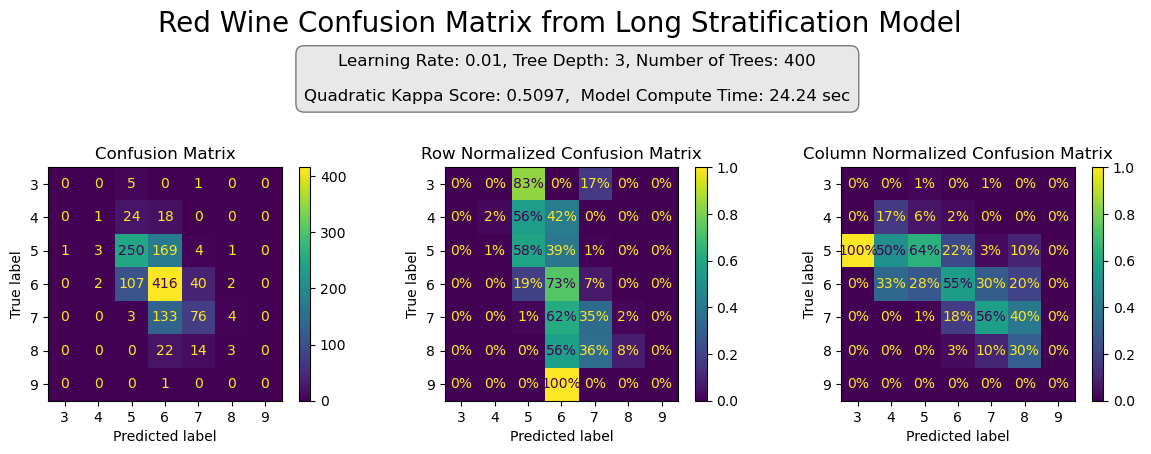

In [64]:
# Create the figure and gridspec
fig = plt.figure(figsize = (12,4.5))
grid_spec = GridSpec(3, 3, figure=fig, width_ratios = [1,1,1], height_ratios=[1,2,10])

# Model specs subplot
model_specs_red_1 =  f"Learning Rate: {long_model['learning_rate']}, Tree Depth: {long_model['max_depth']}, Number of Trees: {long_model['n_estimators']}\n\nQuadratic Kappa Score: {kappa_red_1:.4f},  Model Compute Time: {red_time_1:.2f} sec"   
center_ax = fig.add_subplot(grid_spec[1, :])

# plt.center_ax_adjust(hspace = 0.5)
center_text = center_ax.text(0.5, 0.55, model_specs_red_1, ha='center', fontsize=12,
                           bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=0.5'))
center_ax.axis('off')

# Confusion Matrix Subplot
conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val_red, y_pred_red_1, ax=fig.add_subplot(grid_spec[2, 0]))
conf_matrix_display.ax_.set_title("Confusion Matrix")

# Row (True) Normalized Confusion Matrix Subplot
row_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val_red, y_pred_red_1,
                                                                         normalize='true',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 1]))
row_normalized_conf_matrix_display.ax_.set_title("Row Normalized Confusion Matrix")

# Column (Predicted) Normalized Confusion Matrix Subplot
clm_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val_red, y_pred_red_1,
                                                                         normalize='pred',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 2]))
clm_normalized_conf_matrix_display.ax_.set_title("Column Normalized Confusion Matrix")

# Adjust Layout
plt.tight_layout()
fig.suptitle("Red Wine Confusion Matrix from Long Stratification Model", fontsize=20)

# Save and show the figure
output_filename = f"{gb_png_output_path}/gb_st_skf_cm_red kappa={kappa_red_1:.4f}  est: {long_model['n_estimators']}   LR: {long_model['learning_rate']}   depth: {long_model['max_depth']}  run_time: {red_time_1:.2f}.png"
plt.savefig(output_filename)
plt.show()

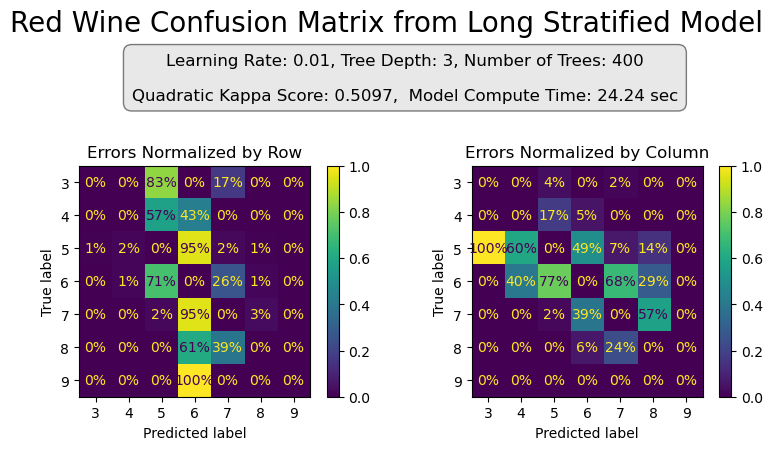

In [65]:
# Create the figure and gridspec
fig = plt.figure(figsize = (8,4.5))
grid_spec = GridSpec(3, 2, figure=fig, width_ratios = [1,1], height_ratios=[1,2,10])

# Model specs subplot
model_specs_red_1 =  f"Learning Rate: {long_model['learning_rate']}, Tree Depth: {long_model['max_depth']}, Number of Trees: {long_model['n_estimators']}\n\nQuadratic Kappa Score: {kappa_red_1:.4f},  Model Compute Time: {red_time_1:.2f} sec"   
center_ax = fig.add_subplot(grid_spec[1, :])

# plt.center_ax_adjust(hspace = 0.5)
center_text = center_ax.text(0.5, 0.55, model_specs_red_1, ha='center', fontsize=12,
                           bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=0.5'))
center_ax.axis('off')

sample_weight = (y_pred_red_1 != y_val_red)
# Row (True) Normalized Confusion Matrix Subplot
row_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val_red, y_pred_red_1,
                                                                         sample_weight = sample_weight,
                                                                         normalize='true',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 0]))
row_normalized_conf_matrix_display.ax_.set_title("Errors Normalized by Row")

# Column (Predicted) Normalized Confusion Matrix Subplot
clm_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val_red, y_pred_red_1,
                                                                         sample_weight = sample_weight,
                                                                         normalize='pred',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 1]))
clm_normalized_conf_matrix_display.ax_.set_title("Errors Normalized by Column")

# Adjust Layout
plt.tight_layout()
fig.suptitle("Red Wine Confusion Matrix from Long Stratified Model", fontsize=20)

# Save and show the figure
output_filename = f"{gb_png_output_path}/gb_st_skf_cm_red_err kappa={kappa_red_1:.4f}  est: {long_model['n_estimators']}   LR: {long_model['learning_rate']}   depth: {long_model['max_depth']}  run_time: {red_time_1:.2f}.png"
plt.savefig(output_filename)
plt.show()

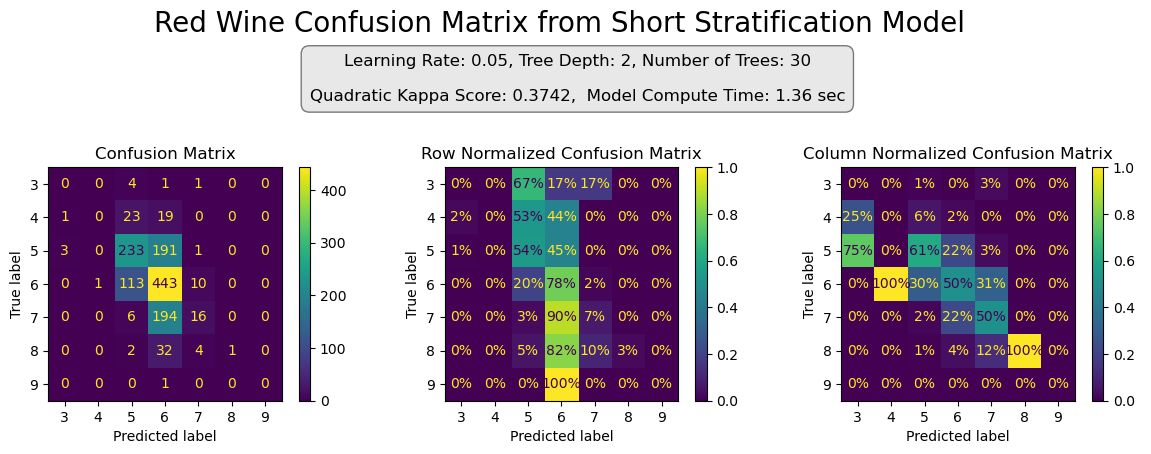

In [66]:
# Create the figure and gridspec
fig = plt.figure(figsize = (12,4.5))
grid_spec = GridSpec(3, 3, figure=fig, width_ratios = [1,1,1], height_ratios=[1,2,10])

# Model specs subplot
model_specs_red_2 =  f"Learning Rate: {short_model['learning_rate']}, Tree Depth: {short_model['max_depth']}, Number of Trees: {short_model['n_estimators']}\n\nQuadratic Kappa Score: {kappa_red_2:.4f},  Model Compute Time: {red_time_2:.2f} sec"   
center_ax = fig.add_subplot(grid_spec[1, :])

# plt.center_ax_adjust(hspace = 0.5)
center_text = center_ax.text(0.5, 0.55, model_specs_red_2, ha='center', fontsize=12,
                           bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=0.5'))
center_ax.axis('off')

# Confusion Matrix Subplot
conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val_red, y_pred_red_2, ax=fig.add_subplot(grid_spec[2, 0]))
conf_matrix_display.ax_.set_title("Confusion Matrix")

# Row (True) Normalized Confusion Matrix Subplot
row_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val_red, y_pred_red_2,
                                                                         normalize='true',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 1]))
row_normalized_conf_matrix_display.ax_.set_title("Row Normalized Confusion Matrix")

# Column (Predicted) Normalized Confusion Matrix Subplot
clm_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val_red, y_pred_red_2,
                                                                         normalize='pred',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 2]))
clm_normalized_conf_matrix_display.ax_.set_title("Column Normalized Confusion Matrix")

# Adjust Layout
plt.tight_layout()
fig.suptitle("Red Wine Confusion Matrix from Short Stratification Model", fontsize=20)

# Save and show the figure
output_filename = f"{gb_png_output_path}/gb_st_skf_cm_red kappa={kappa_red_2:.4f}  est: {short_model['n_estimators']}   LR: {short_model['learning_rate']}   depth: {short_model['max_depth']}  run_time: {red_time_2:.2f}.png"
plt.savefig(output_filename)
plt.show()

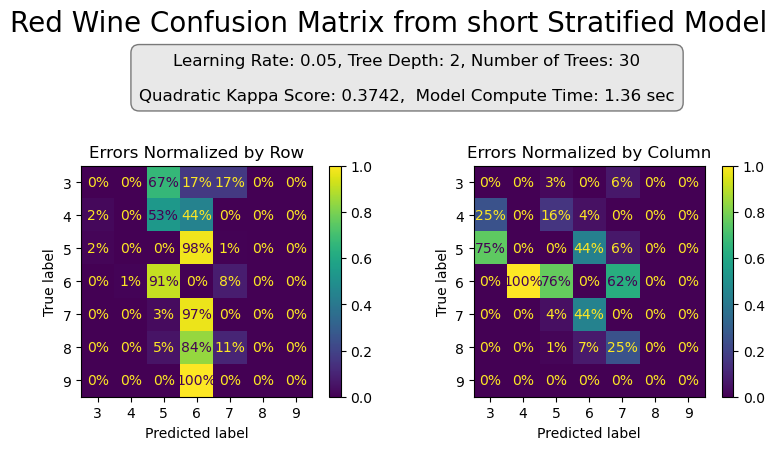

In [67]:
# Create the figure and gridspec
fig = plt.figure(figsize = (8,4.5))
grid_spec = GridSpec(3, 2, figure=fig, width_ratios = [1,1], height_ratios=[1,2,10])

# Model specs subplot
model_specs_red_2 =  f"Learning Rate: {short_model['learning_rate']}, Tree Depth: {short_model['max_depth']}, Number of Trees: {short_model['n_estimators']}\n\nQuadratic Kappa Score: {kappa_red_2:.4f},  Model Compute Time: {red_time_2:.2f} sec"   
center_ax = fig.add_subplot(grid_spec[1, :])

# plt.center_ax_adjust(hspace = 0.5)
center_text = center_ax.text(0.5, 0.55, model_specs_red_2, ha='center', fontsize=12,
                           bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=0.5'))
center_ax.axis('off')

sample_weight = (y_pred_red_2 != y_val_red)
# Row (True) Normalized Confusion Matrix Subplot
row_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val_red, y_pred_red_2,
                                                                         sample_weight = sample_weight,
                                                                         normalize='true',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 0]))
row_normalized_conf_matrix_display.ax_.set_title("Errors Normalized by Row")

# Column (Predicted) Normalized Confusion Matrix Subplot
clm_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val_red, y_pred_red_2,
                                                                         sample_weight = sample_weight,
                                                                         normalize='pred',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 1]))
clm_normalized_conf_matrix_display.ax_.set_title("Errors Normalized by Column")

# Adjust Layout
plt.tight_layout()
fig.suptitle("Red Wine Confusion Matrix from short Stratified Model", fontsize=20)

# Save and show the figure
output_filename = f"{gb_png_output_path}/gb_st_skf_cm_red_err kappa={kappa_red_1:.4f}  est: {short_model['n_estimators']}   LR: {short_model['learning_rate']}   depth: {short_model['max_depth']}  run_time: {red_time_1:.2f}.png"
plt.savefig(output_filename)
plt.show()

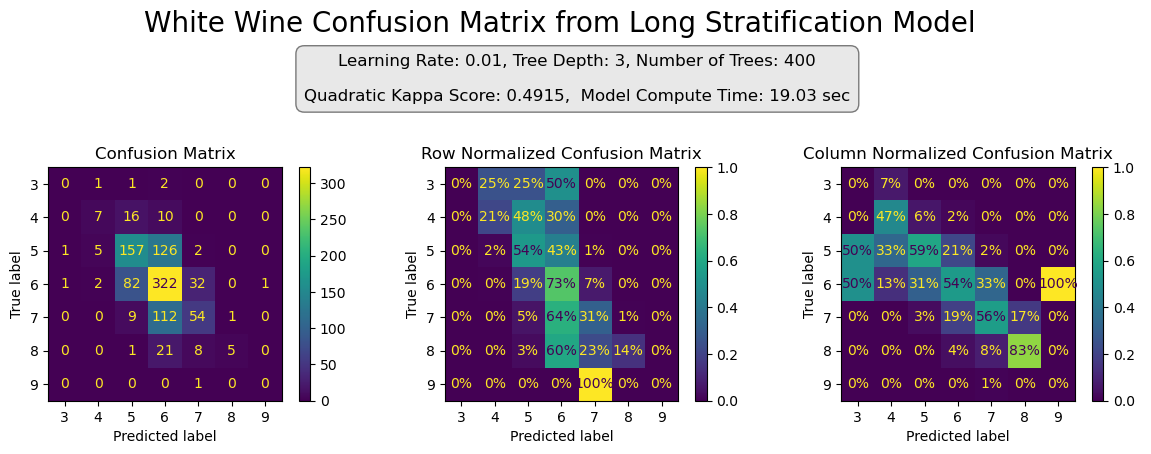

In [68]:
# Create the figure and gridspec
fig = plt.figure(figsize = (12,4.5))
grid_spec = GridSpec(3, 3, figure=fig, width_ratios = [1,1,1], height_ratios=[1,2,10])

# Model specs subplot
model_specs_wh_1 =  f"Learning Rate: {long_model['learning_rate']}, Tree Depth: {long_model['max_depth']}, Number of Trees: {long_model['n_estimators']}\n\nQuadratic Kappa Score: {kappa_wh_1:.4f},  Model Compute Time: {wh_time_1:.2f} sec"   
center_ax = fig.add_subplot(grid_spec[1, :])

# plt.center_ax_adjust(hspace = 0.5)
center_text = center_ax.text(0.5, 0.55, model_specs_wh_1, ha='center', fontsize=12,
                           bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=0.5'))
center_ax.axis('off')

# Confusion Matrix Subplot
conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val_wh, y_pred_wh_1, ax=fig.add_subplot(grid_spec[2, 0]))
conf_matrix_display.ax_.set_title("Confusion Matrix")

# Row (True) Normalized Confusion Matrix Subplot
row_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val_wh, y_pred_wh_1,
                                                                         normalize='true',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 1]))
row_normalized_conf_matrix_display.ax_.set_title("Row Normalized Confusion Matrix")

# Column (Predicted) Normalized Confusion Matrix Subplot
clm_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val_wh, y_pred_wh_1,
                                                                         normalize='pred',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 2]))
clm_normalized_conf_matrix_display.ax_.set_title("Column Normalized Confusion Matrix")

# Adjust Layout
plt.tight_layout()
fig.suptitle("White Wine Confusion Matrix from Long Stratification Model", fontsize=20)

# Save and show the figure
output_filename = f"{gb_png_output_path}/gb_st_skf_cm_wh kappa={kappa_wh_1:.4f}  est: {long_model['n_estimators']}   LR: {long_model['learning_rate']}   depth: {long_model['max_depth']}  run_time: {wh_time_1:.2f}.png"
plt.savefig(output_filename)
plt.show()

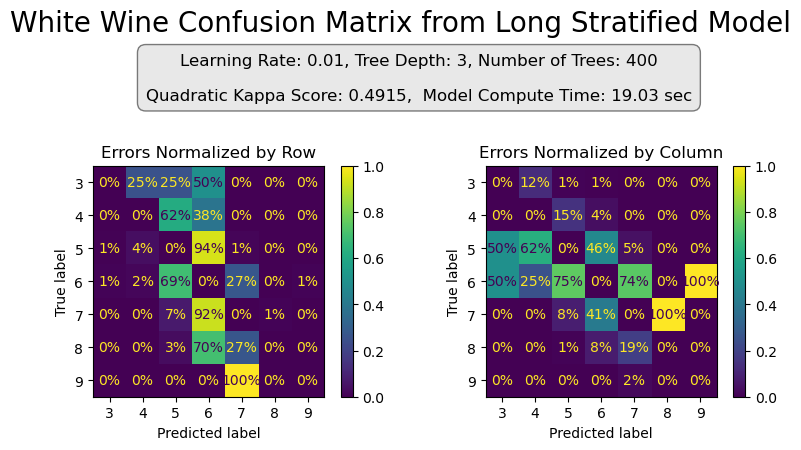

In [69]:
# Create the figure and gridspec
fig = plt.figure(figsize = (8,4.5))
grid_spec = GridSpec(3, 2, figure=fig, width_ratios = [1,1], height_ratios=[1,2,10])

# Model specs subplot
model_specs_wh_1 =  f"Learning Rate: {long_model['learning_rate']}, Tree Depth: {long_model['max_depth']}, Number of Trees: {long_model['n_estimators']}\n\nQuadratic Kappa Score: {kappa_wh_1:.4f},  Model Compute Time: {wh_time_1:.2f} sec"   
center_ax = fig.add_subplot(grid_spec[1, :])

# plt.center_ax_adjust(hspace = 0.5)
center_text = center_ax.text(0.5, 0.55, model_specs_wh_1, ha='center', fontsize=12,
                           bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=0.5'))
center_ax.axis('off')

sample_weight = (y_pred_wh_1 != y_val_wh)
# Row (True) Normalized Confusion Matrix Subplot
row_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val_wh, y_pred_wh_1,
                                                                         sample_weight = sample_weight,
                                                                         normalize='true',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 0]))
row_normalized_conf_matrix_display.ax_.set_title("Errors Normalized by Row")

# Column (Predicted) Normalized Confusion Matrix Subplot
clm_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val_wh, y_pred_wh_1,
                                                                         sample_weight = sample_weight,
                                                                         normalize='pred',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 1]))
clm_normalized_conf_matrix_display.ax_.set_title("Errors Normalized by Column")

# Adjust Layout
plt.tight_layout()
fig.suptitle("White Wine Confusion Matrix from Long Stratified Model", fontsize=20)

# Save and show the figure
output_filename = f"{gb_png_output_path}/gb_st_skf_cm_wh_err kappa={kappa_wh_1:.4f}  est: {long_model['n_estimators']}   LR: {long_model['learning_rate']}   depth: {long_model['max_depth']}  run_time: {wh_time_1:.2f}.png"
plt.savefig(output_filename)
plt.show()

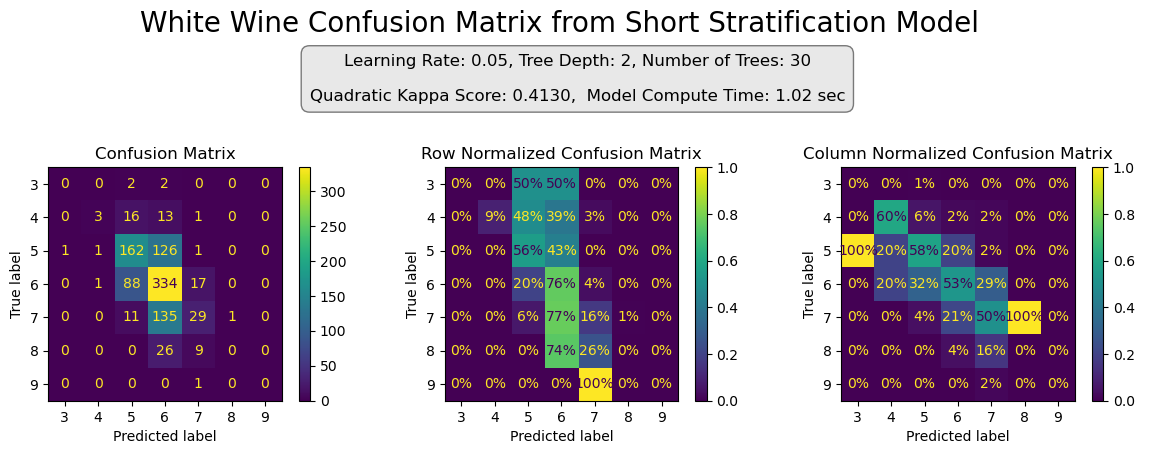

In [70]:
# Create the figure and gridspec
fig = plt.figure(figsize = (12,4.5))
grid_spec = GridSpec(3, 3, figure=fig, width_ratios = [1,1,1], height_ratios=[1,2,10])

# Model specs subplot
model_specs_wh_2 =  f"Learning Rate: {short_model['learning_rate']}, Tree Depth: {short_model['max_depth']}, Number of Trees: {short_model['n_estimators']}\n\nQuadratic Kappa Score: {kappa_wh_2:.4f},  Model Compute Time: {wh_time_2:.2f} sec"   
center_ax = fig.add_subplot(grid_spec[1, :])

# plt.center_ax_adjust(hspace = 0.5)
center_text = center_ax.text(0.5, 0.55, model_specs_wh_2, ha='center', fontsize=12,
                           bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=0.5'))
center_ax.axis('off')

# Confusion Matrix Subplot
conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val_wh, y_pred_wh_2, ax=fig.add_subplot(grid_spec[2, 0]))
conf_matrix_display.ax_.set_title("Confusion Matrix")

# Row (True) Normalized Confusion Matrix Subplot
row_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val_wh, y_pred_wh_2,
                                                                         normalize='true',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 1]))
row_normalized_conf_matrix_display.ax_.set_title("Row Normalized Confusion Matrix")

# Column (Predicted) Normalized Confusion Matrix Subplot
clm_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val_wh, y_pred_wh_2,
                                                                         normalize='pred',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 2]))
clm_normalized_conf_matrix_display.ax_.set_title("Column Normalized Confusion Matrix")

# Adjust Layout
plt.tight_layout()
fig.suptitle("White Wine Confusion Matrix from Short Stratification Model", fontsize=20)

# Save and show the figure
output_filename = f"{gb_png_output_path}/gb_st_skf_cm_wh kappa={kappa_wh_2:.4f}  est: {short_model['n_estimators']}   LR: {short_model['learning_rate']}   depth: {short_model['max_depth']}  run_time: {wh_time_2:.2f}.png"
plt.savefig(output_filename)
plt.show()

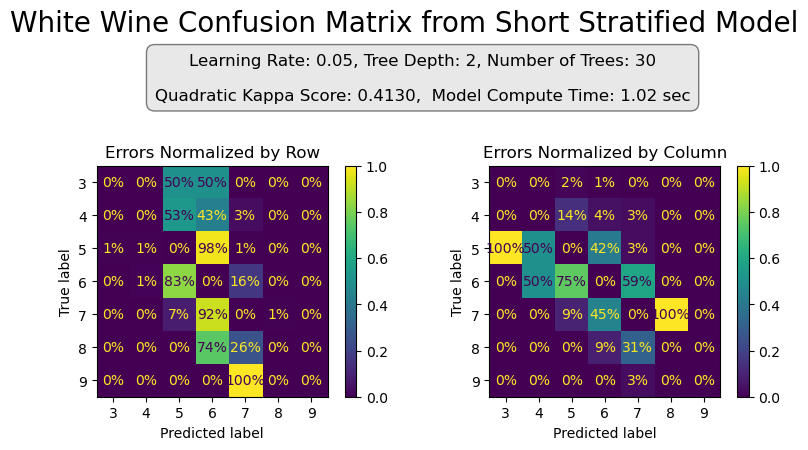

In [71]:
# Create the figure and gridspec
fig = plt.figure(figsize = (8,4.5))
grid_spec = GridSpec(3, 2, figure=fig, width_ratios = [1,1], height_ratios=[1,2,10])

# Model specs subplot
model_specs_wh_2 =  f"Learning Rate: {short_model['learning_rate']}, Tree Depth: {short_model['max_depth']}, Number of Trees: {short_model['n_estimators']}\n\nQuadratic Kappa Score: {kappa_wh_2:.4f},  Model Compute Time: {wh_time_2:.2f} sec"   
center_ax = fig.add_subplot(grid_spec[1, :])

# plt.center_ax_adjust(hspace = 0.5)
center_text = center_ax.text(0.5, 0.55, model_specs_wh_2, ha='center', fontsize=12,
                           bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=0.5'))
center_ax.axis('off')

sample_weight = (y_pred_wh_2 != y_val_wh)
# Row (True) Normalized Confusion Matrix Subplot
row_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val_wh, y_pred_wh_2,
                                                                         sample_weight = sample_weight,
                                                                         normalize='true',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 0]))
row_normalized_conf_matrix_display.ax_.set_title("Errors Normalized by Row")

# Column (Predicted) Normalized Confusion Matrix Subplot
clm_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val_wh, y_pred_wh_2,
                                                                         sample_weight = sample_weight,
                                                                         normalize='pred',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 1]))
clm_normalized_conf_matrix_display.ax_.set_title("Errors Normalized by Column")

# Adjust Layout
plt.tight_layout()
fig.suptitle("White Wine Confusion Matrix from Short Stratified Model", fontsize=20)

# Save and show the figure
output_filename = f"{gb_png_output_path}/gb_st_skf_cm_wh_err kappa={kappa_wh_2:.4f}  est: {short_model['n_estimators']}   LR: {short_model['learning_rate']}   depth: {short_model['max_depth']}  run_time: {wh_time_2:.2f}.png"
plt.savefig(output_filename)
plt.show()

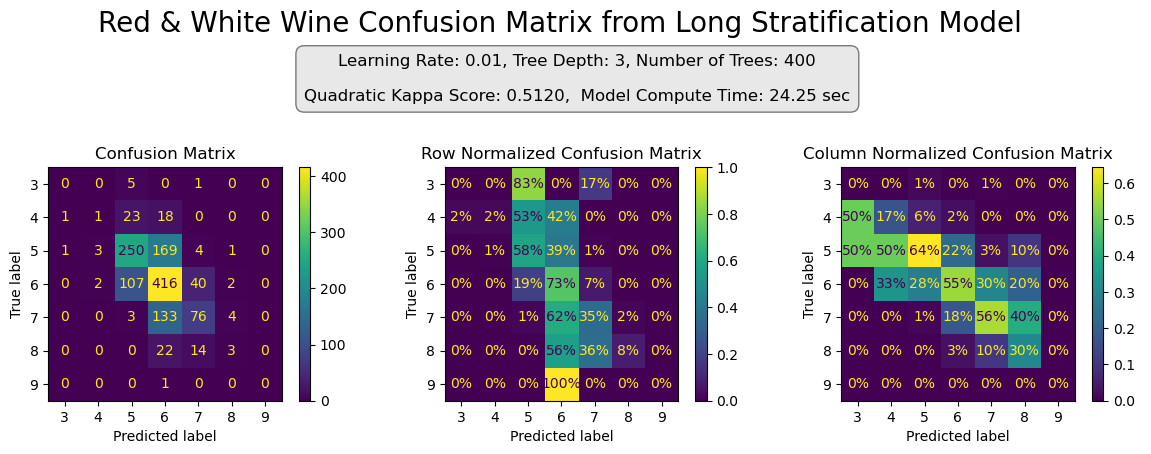

In [72]:
# Create the figure and gridspec
fig = plt.figure(figsize = (12,4.5))
grid_spec = GridSpec(3, 3, figure=fig, width_ratios = [1,1,1], height_ratios=[1,2,10])

# Model specs subplot
model_specs_rwh_1 =  f"Learning Rate: {long_model['learning_rate']}, Tree Depth: {long_model['max_depth']}, Number of Trees: {long_model['n_estimators']}\n\nQuadratic Kappa Score: {kappa_rwh_1:.4f},  Model Compute Time: {rwh_time_1:.2f} sec"   
center_ax = fig.add_subplot(grid_spec[1, :])

# plt.center_ax_adjust(hspace = 0.5)
center_text = center_ax.text(0.5, 0.55, model_specs_rwh_1, ha='center', fontsize=12,
                           bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=0.5'))
center_ax.axis('off')

# Confusion Matrix Subplot
conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val_rwh, y_pred_rwh_1, ax=fig.add_subplot(grid_spec[2, 0]))
conf_matrix_display.ax_.set_title("Confusion Matrix")

# Row (True) Normalized Confusion Matrix Subplot
row_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val_rwh, y_pred_rwh_1,
                                                                         normalize='true',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 1]))
row_normalized_conf_matrix_display.ax_.set_title("Row Normalized Confusion Matrix")

# Column (Predicted) Normalized Confusion Matrix Subplot
clm_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val_rwh, y_pred_rwh_1,
                                                                         normalize='pred',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 2]))
clm_normalized_conf_matrix_display.ax_.set_title("Column Normalized Confusion Matrix")

# Adjust Layout
plt.tight_layout()
fig.suptitle("Red & White Wine Confusion Matrix from Long Stratification Model", fontsize=20)

# Save and show the figure
output_filename = f"{gb_png_output_path}/gb_st_skf_cm_rwh kappa={kappa_rwh_1:.4f}  est: {long_model['n_estimators']}   LR: {long_model['learning_rate']}   depth: {long_model['max_depth']}  run_time: {rwh_time_1:.2f}.png"
plt.savefig(output_filename)
plt.show()

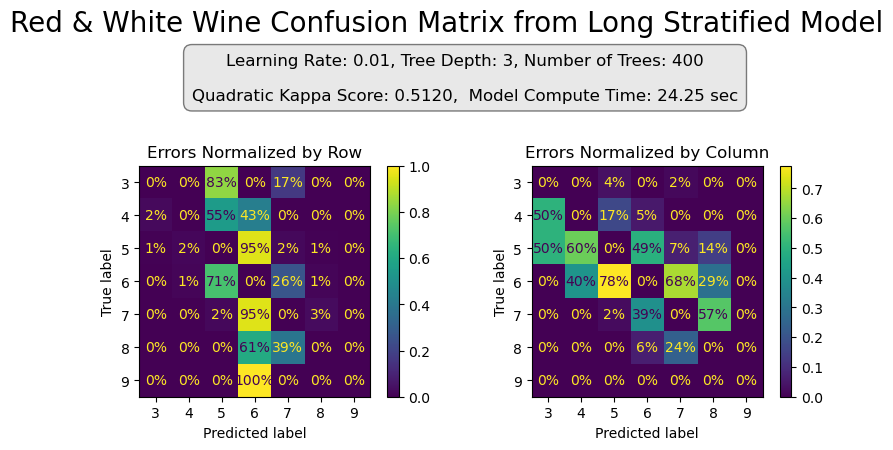

In [73]:
# Create the figure and gridspec
fig = plt.figure(figsize = (8,4.5))
grid_spec = GridSpec(3, 2, figure=fig, width_ratios = [1,1], height_ratios=[1,2,10])

# Model specs subplot
model_specs_rwh_1 =  f"Learning Rate: {long_model['learning_rate']}, Tree Depth: {long_model['max_depth']}, Number of Trees: {long_model['n_estimators']}\n\nQuadratic Kappa Score: {kappa_rwh_1:.4f},  Model Compute Time: {rwh_time_1:.2f} sec"   
center_ax = fig.add_subplot(grid_spec[1, :])

# plt.center_ax_adjust(hspace = 0.5)
center_text = center_ax.text(0.5, 0.55, model_specs_rwh_1, ha='center', fontsize=12,
                           bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=0.5'))
center_ax.axis('off')

sample_weight = (y_pred_rwh_1 != y_val_rwh)
# Row (True) Normalized Confusion Matrix Subplot
row_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val_rwh, y_pred_rwh_1,
                                                                         sample_weight = sample_weight,
                                                                         normalize='true',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 0]))
row_normalized_conf_matrix_display.ax_.set_title("Errors Normalized by Row")

# Column (Predicted) Normalized Confusion Matrix Subplot
clm_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val_rwh, y_pred_rwh_1,
                                                                         sample_weight = sample_weight,
                                                                         normalize='pred',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 1]))
clm_normalized_conf_matrix_display.ax_.set_title("Errors Normalized by Column")

# Adjust Layout
plt.tight_layout()
fig.suptitle("Red & White Wine Confusion Matrix from Long Stratified Model", fontsize=20)

# Save and show the figure
output_filename = f"{gb_png_output_path}/gb_st_skf_cm_rwh_err kappa={kappa_rwh_1:.4f}  est: {long_model['n_estimators']}   LR: {long_model['learning_rate']}   depth: {long_model['max_depth']}  run_time: {rwh_time_1:.2f}.png"
plt.savefig(output_filename)
plt.show()

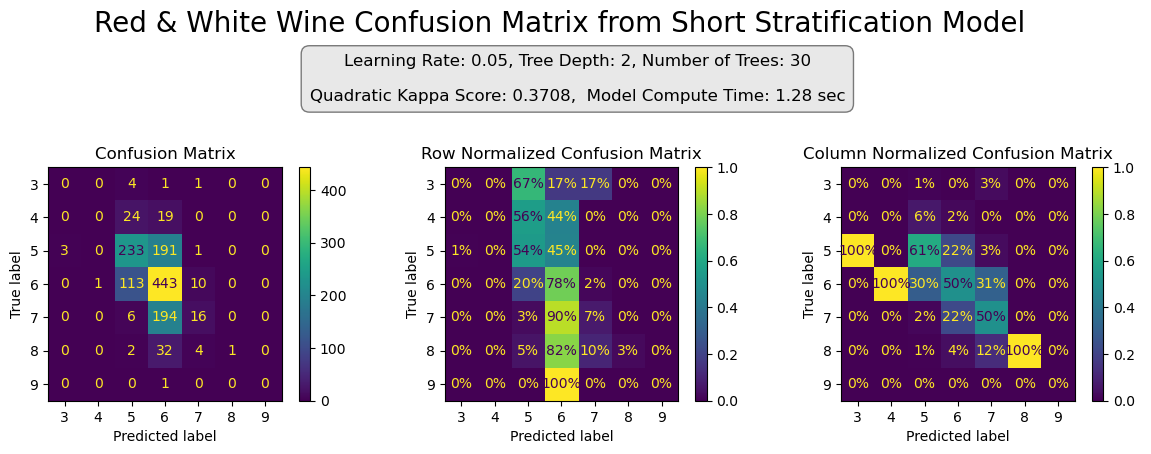

In [74]:
# Create the figure and gridspec
fig = plt.figure(figsize = (12,4.5))
grid_spec = GridSpec(3, 3, figure=fig, width_ratios = [1,1,1], height_ratios=[1,2,10])

# Model specs subplot
model_specs_rwh_2 =  f"Learning Rate: {short_model['learning_rate']}, Tree Depth: {short_model['max_depth']}, Number of Trees: {short_model['n_estimators']}\n\nQuadratic Kappa Score: {kappa_rwh_2:.4f},  Model Compute Time: {rwh_time_2:.2f} sec"   
center_ax = fig.add_subplot(grid_spec[1, :])

# plt.center_ax_adjust(hspace = 0.5)
center_text = center_ax.text(0.5, 0.55, model_specs_rwh_2, ha='center', fontsize=12,
                           bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=0.5'))
center_ax.axis('off')

# Confusion Matrix Subplot
conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val_rwh, y_pred_rwh_2, ax=fig.add_subplot(grid_spec[2, 0]))
conf_matrix_display.ax_.set_title("Confusion Matrix")

# Row (True) Normalized Confusion Matrix Subplot
row_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val_rwh, y_pred_rwh_2,
                                                                         normalize='true',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 1]))
row_normalized_conf_matrix_display.ax_.set_title("Row Normalized Confusion Matrix")

# Column (Predicted) Normalized Confusion Matrix Subplot
clm_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val_rwh, y_pred_rwh_2,
                                                                         normalize='pred',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 2]))
clm_normalized_conf_matrix_display.ax_.set_title("Column Normalized Confusion Matrix")

# Adjust Layout
plt.tight_layout()
fig.suptitle("Red & White Wine Confusion Matrix from Short Stratification Model", fontsize=20)

# Save and show the figure
output_filename = f"{gb_png_output_path}/gb_st_skf_cm_rwh kappa={kappa_rwh_2:.4f}  est: {short_model['n_estimators']}   LR: {short_model['learning_rate']}   depth: {short_model['max_depth']}  run_time: {rwh_time_2:.2f}.png"
plt.savefig(output_filename)
plt.show()

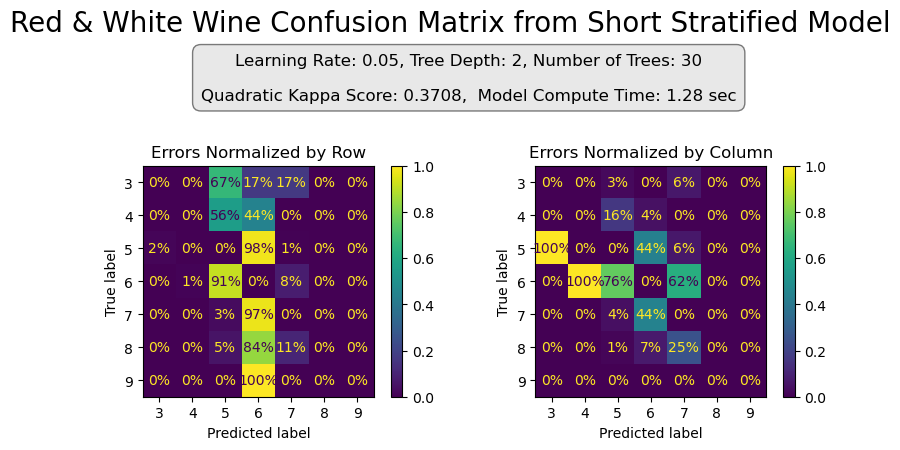

In [75]:
# Create the figure and gridspec
fig = plt.figure(figsize = (8,4.5))
grid_spec = GridSpec(3, 2, figure=fig, width_ratios = [1,1], height_ratios=[1,2,10])

# Model specs subplot
model_specs_rwh_2 =  f"Learning Rate: {short_model['learning_rate']}, Tree Depth: {short_model['max_depth']}, Number of Trees: {short_model['n_estimators']}\n\nQuadratic Kappa Score: {kappa_rwh_2:.4f},  Model Compute Time: {rwh_time_2:.2f} sec"   
center_ax = fig.add_subplot(grid_spec[1, :])

# plt.center_ax_adjust(hspace = 0.5)
center_text = center_ax.text(0.5, 0.55, model_specs_rwh_2, ha='center', fontsize=12,
                           bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=0.5'))
center_ax.axis('off')

sample_weight = (y_pred_rwh_2 != y_val_rwh)
# Row (True) Normalized Confusion Matrix Subplot
row_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val_rwh, y_pred_rwh_2,
                                                                         sample_weight = sample_weight,
                                                                         normalize='true',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 0]))
row_normalized_conf_matrix_display.ax_.set_title("Errors Normalized by Row")

# Column (Predicted) Normalized Confusion Matrix Subplot
clm_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val_rwh, y_pred_rwh_2,
                                                                         sample_weight = sample_weight,
                                                                         normalize='pred',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 1]))
clm_normalized_conf_matrix_display.ax_.set_title("Errors Normalized by Column")

# Adjust Layout
plt.tight_layout()
fig.suptitle("Red & White Wine Confusion Matrix from Short Stratified Model", fontsize=20)

# Save and show the figure
output_filename = f"{gb_png_output_path}/gb_st_skf_cm_rwh_err kappa={kappa_rwh_2:.4f}  est: {short_model['n_estimators']}   LR: {short_model['learning_rate']}   depth: {short_model['max_depth']}  run_time: {rwh_time_2:.2f}.png"
plt.savefig(output_filename)
plt.show()